In [2]:

#  CSV erkennen by David Maksimovic 24.06.2019
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
#import keras

#from keras import regularizers
from tensorflow import keras
from tensorflow.keras import regularizers, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout,LeakyReLU, Activation,ZeroPadding2D, Flatten, Conv2D, MaxPooling2D, BatchNormalization,Concatenate, Reshape, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import time
import pickle
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import pydot_ng as pydot
import numpy as np
import glob
import os
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib.colors import DivergingNorm
from matplotlib import ticker, cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

from numpy import sqrt


if keras.backend.backend() == 'tensorflow':
    from keras import backend as K
    import tensorflow as tf
    from keras.utils.conv_utils import convert_kernel
    
    
########### Normalisieren ###########

#Ist schon normalisiert

Using TensorFlow backend.


In [4]:
model = tf.keras.models.load_model("CNN_PMT+LAPPD(5x5)_V4_PID_120k_tf-improvement-val-acc_0.95.model")

W0706 15:40:00.861972 89116 deprecation.py:506] From C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\Tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0706 15:40:00.861972 89116 deprecation.py:506] From C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\Tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0706 15:40:00.861972 89116 deprecation.py:506] From C:\Program Files (x86)\Microsoft Visual Studio\Shared

In [5]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 50, 120, 400)      7600      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 120, 400)      1440400   
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 60, 400)       0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 25, 60, 400)       1600      
_________________________________________________________________
dropout_10 (Dropout)         (None, 25, 60, 400)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 60, 400)       1440400   
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 25, 60, 400)      

# Load Data

In [6]:
### timeflipped 

X= pickle.load(open("C:/Users/Deep Thought/Documents/Python/CNN_Masterarbeit/BeamlikePI/pickle/X_Beamlike_PID_globalnorm_PMT160andLAPPD5x5_timeflipped_120k_Files_mitTopBottom.pickle","rb"))
Y= pickle.load(open("C:/Users/Deep Thought/Documents/Python/CNN_Masterarbeit/BeamlikePI/pickle/Y_Beamlike_PID_globalnorm_PMT160andLAPPD5x5_timeflipped_120k_Files_mitTopBottom.pickle","rb"))

In [7]:

########### Daten laden ###########
#X= pickle.load(open("C:/Users/Deep Thought/Documents/Python/CNN_Masterarbeit/BeamlikePI/pickle/X_Beamlike_PID_gn_PMT160andLAPPD1x1_120k_Files_mitTopBottom.pickle","rb"))
#Y= pickle.load(open("C:/Users/Deep Thought/Documents/Python/CNN_Masterarbeit/BeamlikePI/pickle/Y_Beamlike_PID_gn_PMT160andLAPPD1x1_120k_Files_mitTopBottom.pickle","rb"))
XMRD = np.load("C:/Users/Deep Thought/Documents/Python/CNN_Masterarbeit/BeamlikePI/Temp/MRD_new.npy")
ParentE= np.load("C:/Users/Deep Thought/Documents/Python/CNN_Masterarbeit/BeamlikePI/Temp/EnergyMother.npy")
MuonE=np.load("C:/Users/Deep Thought/Documents/Python/CNN_Masterarbeit/BeamlikePI/Temp/EnergyMuon.npy",allow_pickle=True)
EE=np.load("C:/Users/Deep Thought/Documents/Python/CNN_Masterarbeit/BeamlikePI/Temp/EnergyElectron.npy",allow_pickle=True)
VisibleE=np.load("C:/Users/Deep Thought/Documents/Python/CNN_Masterarbeit/BeamlikePI/Temp/VisibleEnergy.npy",allow_pickle=True)

# Def Confusion Matrix

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Merge Data

In [9]:
training_data = list(zip(X, Y,XMRD,VisibleE,ParentE))

random.shuffle(training_data)

for sample in Y[:5]:
    print("Eintrag \n", sample)

X1 =[]
Y1 =[]
XMRD1=[]
VisibleE1=[]
ParentE1=[]

for x in training_data[:85000]:
    
    X1.append(x[0])
    Y1.append(x[1])
    XMRD1.append(x[2])
    VisibleE1.append(x[3])
    ParentE1.append(x[4])
    
XTraining = np.array(X1)
YTraining = np.array(Y1)
XMRDTraining= np.array(XMRD1)
VisibleETraining=np.array(VisibleE1)
ParentETraining=np.array(ParentE1)


X2 =[]
Y2 =[]
XMRD2=[]
VisibleE2=[]
ParentE2=[]


for x in training_data[85000:105000]:
    
    X2.append(x[0])
    Y2.append(x[1])
    XMRD2.append(x[2])
    VisibleE2.append(x[3])
    ParentE2.append(x[4])
    
XVal = np.array(X2)
YVal = np.array(Y2)
XMRDVal=np.array(XMRD2)
VisibleEVal=np.array(VisibleE2)
ParentEVal=np.array(ParentE2)

X3 =[]
Y3 =[]
XMRD3=[]
VisibleE3=[]
ParentE3=[]

for x in training_data[105000:]:
    
    X3.append(x[0])
    Y3.append(x[1])
    XMRD3.append(x[2])
    VisibleE3.append(x[3])
    ParentE3.append(x[4])
    
XTest = np.array(X3)
YTest = np.array(Y3)
XMRDTest=np.array(XMRD3)
VisibleETest=np.array(VisibleE3)
ParentETest=np.array(ParentE3)

print(XTraining.shape,XVal.shape,XTest.shape)
print(XTest.shape,YTest.shape,XMRDTest.shape,VisibleETest.shape,ParentETest.shape)
del X,Y,X1,X2,X3,Y1,Y2,Y3,XMRD3,XMRD2,XMRD1,ParentE1,ParentE2,ParentE3,VisibleE3,VisibleE2,VisibleE1

Eintrag 
 [1 0]
Eintrag 
 [1 0]
Eintrag 
 [1 0]
Eintrag 
 [1 0]
Eintrag 
 [1 0]
(85000, 50, 120, 2) (20000, 50, 120, 2) (15005, 50, 120, 2)
(15005, 50, 120, 2) (15005, 2) (15005, 6) (15005, 2) (15005,)


# Safe Testdata

In [10]:
from datetime import datetime
now = datetime.now()
pickle_out = open("pickle/Final/X_Test_{}.pickle".format(now.strftime("%m.%d.%Y")),"wb")
pickle.dump(XTest,pickle_out,protocol=4)
pickle_out.close()
pickle_out = open("pickle/Final/MRD_Test_{}.pickle".format(now.strftime("%m.%d.%Y")),"wb")
pickle.dump(XMRDTest,pickle_out,protocol=4)
pickle_out.close()
pickle_out = open("pickle/Final/VisibleE_Test_{}.pickle".format(now.strftime("%m.%d.%Y")),"wb")
pickle.dump(VisibleETest,pickle_out,protocol=4)
pickle_out.close()
pickle_out = open("pickle/Final/Y_Test_{}.pickle".format(now.strftime("%m.%d.%Y")),"wb")
pickle.dump(YTest,pickle_out,protocol=4)
pickle_out.close()
pickle_out = open("pickle/Final/ParentE_Test_{}.pickle".format(now.strftime("%m.%d.%Y")),"wb")
pickle.dump(ParentETest,pickle_out,protocol=4)
pickle_out.close()

06.07. Files for Björn

# Train a Model

W0628 01:21:47.638636 105648 deprecation.py:506] From C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\Tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 85000 samples, validate on 20000 samples
Epoch 1/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.4031 - acc: 0.8186
Epoch 00001: val_acc improved from -inf to 0.82015, saving model to API-Det+MRD-5x5_tf_improvement-val-acc_0.82.model
85000/85000 [==============================] - 561s 7ms/sample - loss: 0.4030 - acc: 0.8187 - val_loss: 0.4388 - val_acc: 0.8202
Epoch 2/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.3533 - acc: 0.8413
Epoch 00002: val_acc did not improve from 0.82015
85000/85000 [==============================] - 550s 6ms/sample - loss: 0.3533 - acc: 0.8413 - val_loss: 0.3960 - val_acc: 0.8146
Epoch 3/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.3252 - acc: 0.8551
Epoch 00003: val_acc improved from 0.82015 to 0.84510, saving model to API-Det+MRD-5x5_tf_improvement-val-acc_0.85.model
85000/85000 [==============================] - 549s 6ms/sample - loss: 0.3250 - acc: 0.8552 - val_loss: 0.3465 - val_a

Epoch 29/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.1162 - acc: 0.9529
Epoch 00029: val_acc did not improve from 0.93675
85000/85000 [==============================] - 540s 6ms/sample - loss: 0.1161 - acc: 0.9528 - val_loss: 0.1839 - val_acc: 0.9294
Epoch 30/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.1161 - acc: 0.9529
Epoch 00030: val_acc did not improve from 0.93675
85000/85000 [==============================] - 540s 6ms/sample - loss: 0.1162 - acc: 0.9529 - val_loss: 0.1843 - val_acc: 0.9187
Epoch 31/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.1096 - acc: 0.9556
Epoch 00031: val_acc did not improve from 0.93675
85000/85000 [==============================] - 540s 6ms/sample - loss: 0.1095 - acc: 0.9556 - val_loss: 0.2343 - val_acc: 0.9079
Epoch 32/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.1112 - acc: 0.9555
Epoch 00032: val_acc did not improve from 0.93675
85000/85000 [================

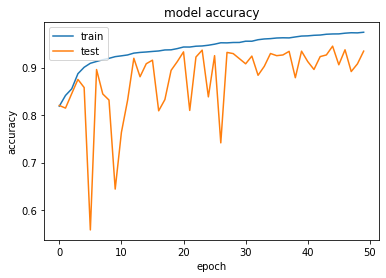

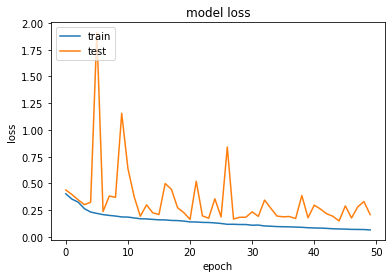

Ende des Versuchs: 


In [6]:


NAME ="MRD+PMT+LAPPD5x5_Energy_Björn"

tensorboard = TensorBoard(log_dir = 'logs\Final\{}'.format(NAME))


inputDet = tf.keras.Input(shape=XTraining.shape[1:], name='PMT+LAPPD')
inputMRD = tf.keras.Input(shape=(5), name='MRD')


x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(inputDet)
x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Flatten()(x)

xP = layers.Dense(32, activation='sigmoid')(x)
#x = layers.BatchNormalization()(x)



mrd = layers.Dense(6, activation='sigmoid')(inputMRD)

mrd =layers.BatchNormalization()(mrd)


x = layers.concatenate([xP, mrd]) #38

x= layers.Dense(100, activation='sigmoid')(x)
x= layers.BatchNormalization()(x)
x= layers.Dropout(0.2) (x)

x= layers.Dense(100, activation='sigmoid')(x)
x= layers.BatchNormalization()(x)
x= layers.Dropout(0.2) (x)


outputs = layers.Dense(2, activation='softmax')(x)




model = tf.keras.Model(inputs=[inputDet, inputMRD], outputs=[outputs], name='Model')
#model.summary()
model.compile(
            optimizer='adam',
            #optimizer = keras.optimizers.RMSprop(1e-3),
            loss='categorical_crossentropy',
            metrics=['acc'])


#filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath="API-Det+MRD-5x5_tf_improvement-val-acc_{val_acc:.2f}.model" 
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=False)
#model Fit



history = model.fit([XTraining,XMRDTraining[:,:5]],
                    YTraining,
                    batch_size=100,
                    #validation_split=0.2,
                    
                    validation_data=([XVal,XMRDVal[:,:5]],YVal),
                    epochs= 50,
                    
                    shuffle=True,
                    class_weight='balanced',
                    callbacks=[
                                #monitor,
                                checkpoint,
                                #tensorboard 
                    ],
                    verbose=1)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("Ende des Versuchs: ")



In [42]:
model = tf.keras.models.load_model("API-Det+MRD-5x5_tf_improvement-val-acc_0.95.model")

In [43]:
score = model.evaluate([XTest,XMRDTest[:,:5]], YTest, verbose=False) 
model.metrics_names
print('Test score: ', score[0])    #Loss on test
print('Test accuracy: ', score[1])

Test score:  0.1606962903892148
Test accuracy:  0.9431523


In [46]:


rounded_labels =np.argmax(YTest, axis=1)
y_prob = np.array(model.predict([XTest,XMRDTest[:,:5]], batch_size=100, verbose=0))
y_classes = y_prob.argmax(axis=-1)
cm = confusion_matrix(rounded_labels, y_classes)
print(cm)


[[6833  600]
 [ 253 7319]]


[[0.91927889 0.08072111]
 [0.03341257 0.96658743]]


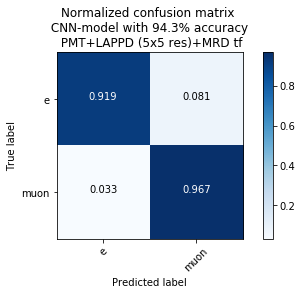

In [47]:
# Reshape into 2 x 2 matrix
cm = cm.reshape((2,2))
 
class_names = ["e", "muon"]
 
    
# Plot normalized confusion matrix
f=plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix \n CNN-model with 94.3% accuracy \n PMT+LAPPD (5x5 res)+MRD tf')
#f.savefig("Confusion-CNN-85-Prozent-MultiChannel-2-conv-130-nodes-2-dense.pdf",format ="pdf", bbox_inches='tight') 
plt.show()

Test for Björn

Train on 85000 samples, validate on 20000 samples
Epoch 1/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.4074 - acc: 0.8158
Epoch 00001: val_acc improved from -inf to 0.68100, saving model to API-Det+MRD(5)-5x5_tf_gn_improvement-val-acc_0.68.model
85000/85000 [==============================] - 560s 7ms/sample - loss: 0.4073 - acc: 0.8158 - val_loss: 0.6728 - val_acc: 0.6810
Epoch 2/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.3577 - acc: 0.8385
Epoch 00002: val_acc improved from 0.68100 to 0.78610, saving model to API-Det+MRD(5)-5x5_tf_gn_improvement-val-acc_0.79.model
85000/85000 [==============================] - 547s 6ms/sample - loss: 0.3576 - acc: 0.8386 - val_loss: 0.4631 - val_acc: 0.7861
Epoch 3/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.3463 - acc: 0.8442
Epoch 00003: val_acc did not improve from 0.78610
85000/85000 [==============================] - 546s 6ms/sample - loss: 0.3463 - acc: 0.8443 - val_loss: 0.

Epoch 29/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.1224 - acc: 0.9498
Epoch 00029: val_acc did not improve from 0.93915
85000/85000 [==============================] - 540s 6ms/sample - loss: 0.1224 - acc: 0.9498 - val_loss: 0.1768 - val_acc: 0.9320
Epoch 30/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.1206 - acc: 0.9513
Epoch 00030: val_acc did not improve from 0.93915
85000/85000 [==============================] - 540s 6ms/sample - loss: 0.1206 - acc: 0.9513 - val_loss: 0.1873 - val_acc: 0.9286
Epoch 31/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.1154 - acc: 0.9537
Epoch 00031: val_acc did not improve from 0.93915
85000/85000 [==============================] - 540s 6ms/sample - loss: 0.1154 - acc: 0.9536 - val_loss: 0.1921 - val_acc: 0.9293
Epoch 32/50
84900/85000 [============================>.] - ETA: 0s - loss: 0.1175 - acc: 0.9522
Epoch 00032: val_acc did not improve from 0.93915
85000/85000 [================

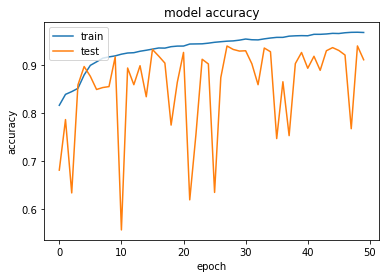

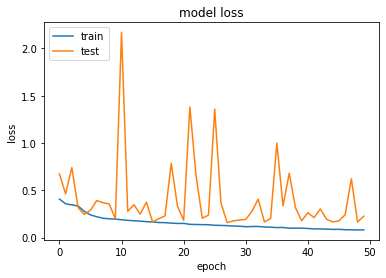

Ende des Versuchs: 


In [13]:


NAME ="MRD+PMT+LAPPD5x5_Energy_Björn"

tensorboard = TensorBoard(log_dir = 'logs\Final\{}'.format(NAME))


inputDet = tf.keras.Input(shape=XTraining.shape[1:], name='PMTLAPPD')
inputMRD = tf.keras.Input(shape=(5), name='MRD')


x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(inputDet)
x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.Conv2D(400, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Flatten()(x)

xP = layers.Dense(32, activation='sigmoid')(x)
#x = layers.BatchNormalization()(x)



mrd = layers.Dense(6, activation='sigmoid')(inputMRD)

mrd =layers.BatchNormalization()(mrd)


x = layers.concatenate([xP, mrd]) #38

x= layers.Dense(100, activation='sigmoid')(x)
x= layers.BatchNormalization()(x)
x= layers.Dropout(0.2) (x)

x= layers.Dense(100, activation='sigmoid')(x)
x= layers.BatchNormalization()(x)
x= layers.Dropout(0.2) (x)


outputs = layers.Dense(2, activation='softmax')(x)




model = tf.keras.Model(inputs=[inputDet, inputMRD], outputs=[outputs], name='Model')
#model.summary()
model.compile(
            optimizer='adam',
            #optimizer = keras.optimizers.RMSprop(1e-3),
            loss='categorical_crossentropy',
            metrics=['acc'])


#filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath="API-Det+MRD(5)-5x5_tf_gn_improvement-val-acc_{val_acc:.2f}.model" 
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=False)
#model Fit



history = model.fit([XTraining,XMRDTraining[:,:5]],
                    YTraining,
                    batch_size=100,
                    #validation_split=0.2,
                    
                    validation_data=([XVal,XMRDVal[:,:5]],YVal),
                    epochs= 50,
                    
                    shuffle=True,
                    class_weight='balanced',
                    callbacks=[
                                #monitor,
                                checkpoint,
                                #tensorboard 
                    ],
                    verbose=1)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("Ende des Versuchs: ")

# Perceptron

In [33]:
Tiefe = [3]
Batchgrose = [128]
Breite = [600]# es sid nur 400
# dense_layers = [3]
# layer_sizes = [160]
# conv_layers = [3]
# kernal_size = [(3,3)]
#Ist schon normalisiert

#NAME ="BigData_Beamlike-32k-toy_res"

#tensorboard = TensorBoard(log_dir = 'logs\{}'.format(NAME))


inputDet = tf.keras.Input(shape=XTraining.shape[1:], name='PMT_Lappd')
inputMRD = tf.keras.Input(shape=(5), name='MRD')

mrd = layers.Dense(6, activation='sigmoid')(inputMRD)
mrd = layers.BatchNormalization()(mrd)
xP =layers.Flatten()(inputDet)
x = layers.concatenate([mrd, xP])


x = layers.Dense(600, activation='sigmoid')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(600, activation='sigmoid')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(600, activation='sigmoid')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(600, activation='sigmoid')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)


outputs = layers.Dense(2, activation='softmax')(x)



model = tf.keras.Model(inputs=[inputDet, inputMRD], outputs=[outputs], name='Model')

model.summary()




Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MRD (InputLayer)                [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 6)            36          MRD[0][0]                        
__________________________________________________________________________________________________
PMT_Lappd (InputLayer)          [(None, 50, 120, 2)] 0                                            
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 6)            24          dense_44[0][0]                   
______________________________________________________________________________________________

Train on 85000 samples, validate on 20000 samples
Epoch 1/80
84900/85000 [============================>.] - ETA: 0s - loss: 0.4987 - acc: 0.7735
Epoch 00001: val_acc improved from -inf to 0.68395, saving model to Perceptron-Det+MRD(5)_5x5_tf-improvement-val_V2-acc_0.68.model
85000/85000 [==============================] - 29s 342us/sample - loss: 0.4986 - acc: 0.7735 - val_loss: 0.6457 - val_acc: 0.6840
Epoch 2/80
84700/85000 [============================>.] - ETA: 0s - loss: 0.4359 - acc: 0.7982
Epoch 00002: val_acc did not improve from 0.68395
85000/85000 [==============================] - 21s 245us/sample - loss: 0.4359 - acc: 0.7982 - val_loss: 1.1407 - val_acc: 0.5002
Epoch 3/80
84900/85000 [============================>.] - ETA: 0s - loss: 0.4419 - acc: 0.7961
Epoch 00003: val_acc did not improve from 0.68395
85000/85000 [==============================] - 21s 245us/sample - loss: 0.4420 - acc: 0.7960 - val_loss: 1.4209 - val_acc: 0.5002
Epoch 4/80
84900/85000 [====================

Epoch 29/80
84700/85000 [============================>.] - ETA: 0s - loss: 0.3537 - acc: 0.8423
Epoch 00029: val_acc did not improve from 0.82370
85000/85000 [==============================] - 20s 234us/sample - loss: 0.3538 - acc: 0.8423 - val_loss: 0.4138 - val_acc: 0.8141
Epoch 30/80
84900/85000 [============================>.] - ETA: 0s - loss: 0.3503 - acc: 0.8435
Epoch 00030: val_acc did not improve from 0.82370
85000/85000 [==============================] - 20s 234us/sample - loss: 0.3504 - acc: 0.8435 - val_loss: 0.4884 - val_acc: 0.7840
Epoch 31/80
84800/85000 [============================>.] - ETA: 0s - loss: 0.3520 - acc: 0.8429
Epoch 00031: val_acc did not improve from 0.82370
85000/85000 [==============================] - 20s 234us/sample - loss: 0.3520 - acc: 0.8429 - val_loss: 0.4179 - val_acc: 0.8156
Epoch 32/80
84900/85000 [============================>.] - ETA: 0s - loss: 0.3531 - acc: 0.8430
Epoch 00032: val_acc did not improve from 0.82370
85000/85000 [=============

Epoch 59/80
84700/85000 [============================>.] - ETA: 0s - loss: 0.3206 - acc: 0.8589
Epoch 00059: val_acc did not improve from 0.82370
85000/85000 [==============================] - 20s 234us/sample - loss: 0.3206 - acc: 0.8589 - val_loss: 0.4302 - val_acc: 0.8167
Epoch 60/80
84600/85000 [============================>.] - ETA: 0s - loss: 0.3192 - acc: 0.8611
Epoch 00060: val_acc did not improve from 0.82370
85000/85000 [==============================] - 20s 234us/sample - loss: 0.3191 - acc: 0.8611 - val_loss: 0.4366 - val_acc: 0.8160
Epoch 61/80
84900/85000 [============================>.] - ETA: 0s - loss: 0.3193 - acc: 0.8589
Epoch 00061: val_acc did not improve from 0.82370
85000/85000 [==============================] - 20s 233us/sample - loss: 0.3191 - acc: 0.8590 - val_loss: 0.4530 - val_acc: 0.8132
Epoch 62/80
84800/85000 [============================>.] - ETA: 0s - loss: 0.3233 - acc: 0.8579- ETA: 0s - loss: 0.3232 - acc: 0.85
Epoch 00062: val_acc did not improve fro

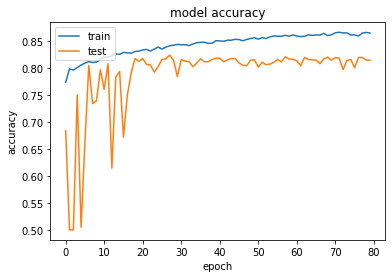

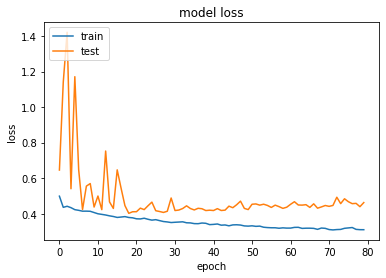

Ende des Versuchs: 
82.6
82.9


In [34]:


#Model compile
model.compile(
            optimizer='adam',
            #optimizer = keras.optimizers.RMSprop(1e-3),
            loss='categorical_crossentropy',
            metrics=['acc'])


#filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath="Perceptron-Det+MRD(5)_5x5_tf-improvement-val_V2-acc_{val_acc:.2f}.model" 
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=False)
#model Fit


history = model.fit([XTraining,XMRDTraining[:,:5]],
                    YTraining,
                    batch_size=100,
                    #validation_split=0.2,
                    
                    validation_data=([XVal,XMRDVal[:,:5]],YVal),
                    epochs= 80,

                    shuffle=True,
                    class_weight='balanced',
                    callbacks=[
                                #monitor,
                                checkpoint,
                                #tensorboard 
                    ],
                    verbose=1)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("Ende des Versuchs: ")
#87.8
print(82.6)
print(82.9)

In [37]:
model = tf.keras.models.load_model("Perceptron-Det+MRD(5)_5x5_tf-improvement-val-acc_0.83.model")

In [38]:
score = model.evaluate([XTest,XMRDTest[:,:5]], YTest, verbose=False) 
model.metrics_names
print('Test score: ', score[0])    #Loss on test
print('Test accuracy: ', score[1])

Test score:  0.43180155316935664
Test accuracy:  0.8274575


In [39]:


rounded_labels =np.argmax(YTest, axis=1)
y_prob = np.array(model.predict([XTest,XMRDTest[:,:5]], batch_size=128, verbose=0))
y_classes = y_prob.argmax(axis=-1)
cm = confusion_matrix(rounded_labels, y_classes)
print(cm)


[[5950 1483]
 [1106 6466]]


In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[0.80048433 0.19951567]
 [0.14606445 0.85393555]]


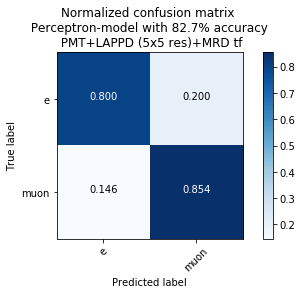

In [41]:
# Reshape into 2 x 2 matrix
cm = cm.reshape((2,2))
 
class_names = ["e", "muon"]
 
    
# Plot normalized confusion matrix
f=plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix \n Perceptron-model with 82.7% accuracy \n PMT+LAPPD (5x5 res)+MRD tf')
#f.savefig("Confusion-CNN-85-Prozent-MultiChannel-2-conv-130-nodes-2-dense.pdf",format ="pdf", bbox_inches='tight') 
plt.show()

# Load Model

In [14]:
model = tf.keras.models.load_model("API-Det+MRD-5x5_improvement_EnergyTester_V2-val-acc_0.94.model")

In [16]:
score = model.evaluate([XTest,XMRDTest], YTest, verbose=False) 
model.metrics_names
print('Test score: ', score[0])    #Loss on test
print('Test accuracy: ', score[1])

Test score:  0.1778814691795742
Test accuracy:  0.9396868


Train on 85000 samples, validate on 20000 samples
Epoch 1/38
84900/85000 [============================>.] - ETA: 0s - loss: 0.0779 - acc: 0.9705
Epoch 00001: val_acc improved from -inf to 0.89665, saving model to API-Det+MRD-5x5_improvement_EnergyTester_V2-val-acc_0.90.model
85000/85000 [==============================] - 471s 6ms/sample - loss: 0.0779 - acc: 0.9705 - val_loss: 0.2892 - val_acc: 0.8967
Epoch 2/38
84900/85000 [============================>.] - ETA: 0s - loss: 0.0772 - acc: 0.9710
Epoch 00002: val_acc improved from 0.89665 to 0.92840, saving model to API-Det+MRD-5x5_improvement_EnergyTester_V2-val-acc_0.93.model
85000/85000 [==============================] - 470s 6ms/sample - loss: 0.0773 - acc: 0.9709 - val_loss: 0.2004 - val_acc: 0.9284
Epoch 3/38
84900/85000 [============================>.] - ETA: 0s - loss: 0.0731 - acc: 0.9721
Epoch 00003: val_acc improved from 0.92840 to 0.94220, saving model to API-Det+MRD-5x5_improvement_EnergyTester_V2-val-acc_0.94.model
85000/85

Epoch 30/38
84900/85000 [============================>.] - ETA: 0s - loss: 0.0318 - acc: 0.9887
Epoch 00030: val_acc did not improve from 0.94335
85000/85000 [==============================] - 470s 6ms/sample - loss: 0.0318 - acc: 0.9887 - val_loss: 0.2876 - val_acc: 0.9290
Epoch 31/38
84900/85000 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9891
Epoch 00031: val_acc did not improve from 0.94335
85000/85000 [==============================] - 470s 6ms/sample - loss: 0.0302 - acc: 0.9891 - val_loss: 0.2166 - val_acc: 0.9363
Epoch 32/38
84900/85000 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9891
Epoch 00032: val_acc did not improve from 0.94335
85000/85000 [==============================] - 471s 6ms/sample - loss: 0.0303 - acc: 0.9891 - val_loss: 0.3984 - val_acc: 0.9155
Epoch 33/38
84900/85000 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9891
Epoch 00033: val_acc did not improve from 0.94335
85000/85000 [================

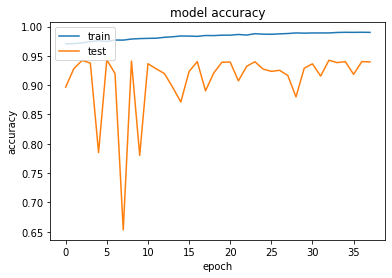

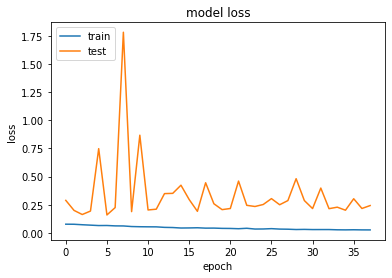

In [13]:
filepath="API-Det+MRD-5x5_improvement_EnergyTester_V2-val-acc_{val_acc:.2f}.model" 
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=False)
#model Fit



history = model.fit([XTraining,XMRDTraining],
                    YTraining,
                    batch_size=100,
                    #validation_split=0.2,
                    
                    validation_data=([XVal,XMRDVal],YVal),
                    epochs= 38,
                    
                    shuffle=True,
                    class_weight='balanced',
                    callbacks=[
                                #monitor,
                                checkpoint,
                                #tensorboard 
                    ],
                    verbose=1)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 85000 samples, validate on 20000 samples
Epoch 1/38
84700/85000 [============================>.] - ETA: 0s - loss: 0.3394 - acc: 0.8519
Epoch 00001: val_acc improved from -inf to 0.82360, saving model to API-Det+MRD-improvement_EnergyTester-val-acc_0.82.model
85000/85000 [==============================] - 16s 194us/sample - loss: 0.3390 - acc: 0.8521 - val_loss: 0.4543 - val_acc: 0.8236
Epoch 2/38
84700/85000 [============================>.] - ETA: 0s - loss: 0.2419 - acc: 0.9004
Epoch 00002: val_acc did not improve from 0.82360
85000/85000 [==============================] - 12s 144us/sample - loss: 0.2419 - acc: 0.9004 - val_loss: 0.8676 - val_acc: 0.6820
Epoch 3/38
84700/85000 [============================>.] - ETA: 0s - loss: 0.2159 - acc: 0.9129
Epoch 00003: val_acc improved from 0.82360 to 0.92585, saving model to API-Det+MRD-improvement_EnergyTester-val-acc_0.93.model
85000/85000 [==============================] - 12s 146us/sample - loss: 0.2159 - acc: 0.9129 - val_loss:

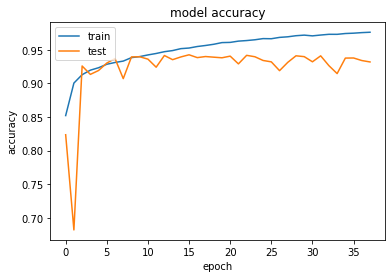

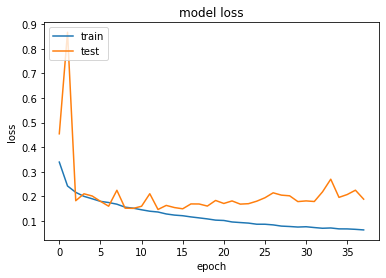

Ende des Versuchs: 


In [39]:
### MRD + ####
inputDet = tf.keras.Input(shape=XTraining.shape[1:], name='PMT')
inputMRD = tf.keras.Input(shape=(6), name='MRD')


x = layers.Conv2D(160, kernel_size=(3,3),activation ='relu',padding='same')(inputDet)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(160, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(160, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)


x = layers.Flatten()(x)

x = layers.Dense(512, activation='sigmoid')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(492, activation='sigmoid')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='sigmoid')(x)
x = layers.BatchNormalization()(x)
xP = layers.Dropout(0.2)(x)

##### MRD #####

mrd = layers.Dense(6, activation='sigmoid')(inputMRD)

##### Concatenate #####
x = layers.concatenate([xP, mrd]) #38


##### Dense #####
x= layers.Dense(100, activation='sigmoid')(x)
x= layers.BatchNormalization()(x)

x= layers.Dense(100, activation='sigmoid')(x)
x= layers.BatchNormalization()(x)



##### Output #####
outputs = layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs=[inputDet, inputMRD], outputs=[outputs], name='Model')
#model.summary()
model.compile(
            optimizer='adam',
            #optimizer = keras.optimizers.RMSprop(1e-3),
            loss='categorical_crossentropy',
            metrics=['acc'])


#filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath="API-Det+MRD-improvement_EnergyTester-val-acc_{val_acc:.2f}.model" 
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=False)
#model Fit



history = model.fit([XTraining,XMRDTraining[:,:5]],
                    YTraining,
                    batch_size=100,
                    #validation_split=0.2,
                    
                    validation_data=([XVal,XMRDVal[:,:5]],YVal),
                    epochs= 38,
                    
                    shuffle=True,
                    class_weight='balanced',
                    callbacks=[
                                #monitor,
                                checkpoint,
                                #tensorboard 
                    ],
                    verbose=1)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("Ende des Versuchs: ")

Train on 85000 samples, validate on 20000 samples
Epoch 1/38
84800/85000 [============================>.] - ETA: 0s - loss: 0.3562 - acc: 0.8452
Epoch 00001: val_acc improved from -inf to 0.88205, saving model to API-Det+MRD-improvement_EnergyTester_V2-val-acc_0.88.model
85000/85000 [==============================] - 27s 320us/sample - loss: 0.3561 - acc: 0.8452 - val_loss: 0.2839 - val_acc: 0.8820
Epoch 2/38
84700/85000 [============================>.] - ETA: 0s - loss: 0.2584 - acc: 0.8933
Epoch 00002: val_acc improved from 0.88205 to 0.90420, saving model to API-Det+MRD-improvement_EnergyTester_V2-val-acc_0.90.model
85000/85000 [==============================] - 18s 211us/sample - loss: 0.2585 - acc: 0.8933 - val_loss: 0.2269 - val_acc: 0.9042
Epoch 3/38
84900/85000 [============================>.] - ETA: 0s - loss: 0.2328 - acc: 0.9061
Epoch 00003: val_acc did not improve from 0.90420
85000/85000 [==============================] - 18s 211us/sample - loss: 0.2327 - acc: 0.9062 - val

Epoch 29/38
84900/85000 [============================>.] - ETA: 0s - loss: 0.1662 - acc: 0.9313
Epoch 00029: val_acc did not improve from 0.93765
85000/85000 [==============================] - 18s 208us/sample - loss: 0.1661 - acc: 0.9313 - val_loss: 0.1624 - val_acc: 0.9338
Epoch 30/38
84900/85000 [============================>.] - ETA: 0s - loss: 0.1430 - acc: 0.9428
Epoch 00030: val_acc did not improve from 0.93765
85000/85000 [==============================] - 18s 208us/sample - loss: 0.1429 - acc: 0.9428 - val_loss: 0.1689 - val_acc: 0.9309
Epoch 31/38
84700/85000 [============================>.] - ETA: 0s - loss: 0.1473 - acc: 0.9412
Epoch 00031: val_acc did not improve from 0.93765
85000/85000 [==============================] - 18s 212us/sample - loss: 0.1472 - acc: 0.9411 - val_loss: 0.1654 - val_acc: 0.9323
Epoch 32/38
84700/85000 [============================>.] - ETA: 0s - loss: 0.1464 - acc: 0.9417
Epoch 00032: val_acc did not improve from 0.93765
85000/85000 [=============

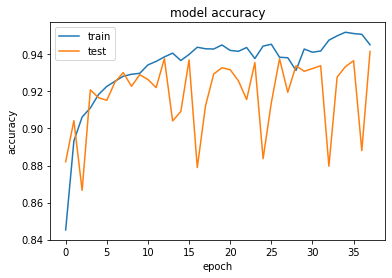

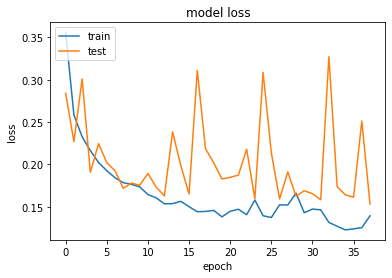

Ende des Versuchs: 


In [41]:
### MRD without ####
inputDet = tf.keras.Input(shape=XTraining.shape[1:], name='PMT')
inputMRD = tf.keras.Input(shape=(5), name='MRD')


x = layers.Conv2D(160, kernel_size=(3,3),activation ='relu',padding='same')(inputDet)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(160, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(160, kernel_size=(3,3),activation ='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)


x = layers.Flatten()(x)

x = layers.Dense(512, activation='sigmoid')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(492, activation='sigmoid')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='sigmoid')(x)
x = layers.BatchNormalization()(x)
xP = layers.Dropout(0.2)(x)

##### MRD #####

mrd = layers.Dense(6, activation='sigmoid')(inputMRD)

##### Concatenate #####
x = layers.concatenate([xP, mrd]) #38


##### Dense #####
x= layers.Dense(100, activation='sigmoid')(x)
x= layers.BatchNormalization()(x)

x= layers.Dense(100, activation='sigmoid')(x)
x= layers.BatchNormalization()(x)

x= layers.Dense(100, activation='sigmoid')(x)
x= layers.BatchNormalization()(x)

x= layers.Dense(100, activation='sigmoid')(x)
x= layers.BatchNormalization()(x)

x= layers.Dense(100, activation='sigmoid')(x)
x= layers.BatchNormalization()(x)

x= layers.Dense(100, activation='sigmoid')(x)
x= layers.BatchNormalization()(x)

x= layers.Dense(100, activation='sigmoid')(x)
x= layers.BatchNormalization()(x)
##### Output #####
outputs = layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs=[inputDet, inputMRD], outputs=[outputs], name='Model')
#model.summary()
model.compile(
            optimizer='adam',
            #optimizer = keras.optimizers.RMSprop(1e-3),
            loss='categorical_crossentropy',
            metrics=['acc'])


#filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath="API-Det+MRD-improvement_EnergyTester_V2-val-acc_{val_acc:.2f}.model" 
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=False)
#model Fit



history = model.fit([XTraining,XMRDTraining[:,:5]],
                    YTraining,
                    batch_size=100,
                    #validation_split=0.2,
                    
                    validation_data=([XVal,XMRDVal[:,:5]],YVal),
                    epochs= 38,
                    
                    shuffle=True,
                    class_weight='balanced',
                    callbacks=[
                                #monitor,
                                checkpoint,
                                #tensorboard 
                    ],
                    verbose=1)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("Ende des Versuchs: ")

# Load Model

In [42]:
model = tf.keras.models.load_model("API-Det+MRD-improvement_EnergyTester-val-acc_0.94.model")

In [43]:
score = model.evaluate([XTest,XMRDTest[:,:5]], YTest, verbose=False) 
model.metrics_names
print('Test score: ', score[0])    #Loss on test
print('Test accuracy: ', score[1])

Test score:  0.15912226837740387
Test accuracy:  0.9368877


# Feature Map

In [44]:
feature_maps = model.predict([XTest,XMRDTest[:,:5]])

# Visible Energy vs Accurancy

In [45]:
colorSR=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
colorMR=(1, 0.5176470588235295, 0.3215686274509804)

In [46]:
ViEnMuon=[]
ViEnEl=[]

for event in range(len(YTest)):
    if YTest[event,0] >0.5:
        ViEnMuon.append((VisibleETest[event]))

    if YTest[event,1] >0.5:
        ViEnEl.append((VisibleETest[event]))

ViEnMuon=np.array(ViEnMuon)
ViEnEl=np.array(ViEnEl)

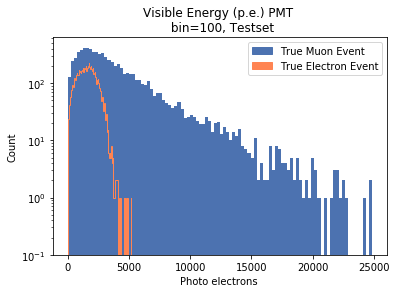

In [47]:
#### PMT Photoelectorns 
plt.hist(ViEnMuon[:,0], bins=100,histtype='stepfilled',log=True,color=colorSR)
plt.hist(ViEnEl[:,0], bins=100 , histtype='step',log=True,color=colorMR)
plt.title("Visible Energy (p.e.) PMT \n bin=100, Testset")
plt.xlabel("Photo electrons ")
plt.ylabel("Count")
plt.grid(False)

red_patch = mpatches.Patch(color=colorSR, label='True Muon Event')
blue_patch = mpatches.Patch(color=colorMR, label='True Electron Event')


plt.legend(handles=[red_patch, blue_patch],loc='upper right')


plt.show()

Nun alle

In [66]:
max(VisibleE[50000:,0])

25079.2

In [59]:
unique, counts = np.unique(Y, return_counts=True, axis=0)
print(counts)
print(unique)
print(100/(counts[0]+counts[1])*counts[1])


[59977 60028]
[[0 1]
 [1 0]]
50.021249114620225


In [77]:
ViEnMuon=[]
ViEnEl=[]

for event in range(len(YTest)):
    if YTest[event,0] >0.5:
        ViEnEl.append(VisibleETest[event])

    if YTest[event,1] >0.5:
        ViEnMuon.append(VisibleETest[event])

ViEnMuon=np.array(ViEnMuon)
ViEnEl=np.array(ViEnEl)

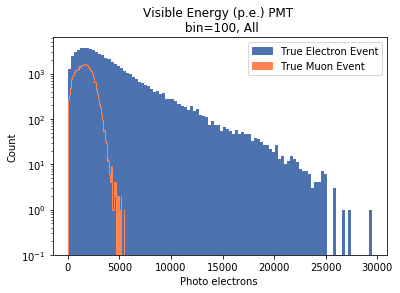

In [71]:
#### PMT Photoelectorns 
plt.hist(VisibleE[:60028,0], bins=100,histtype='stepfilled',log=True,color=colorSR)
plt.hist(VisibleE[60028:,0], bins=100 , histtype='step',log=True,color=colorMR)
plt.title("Visible Energy (p.e.) PMT \n bin=100, All")
plt.xlabel("Photo electrons ")
plt.ylabel("Count")
plt.grid(False)

red_patch = mpatches.Patch(color=colorSR, label='True Electron Event')
blue_patch = mpatches.Patch(color=colorMR, label='True Muon Event')


plt.legend(handles=[red_patch, blue_patch],loc='upper right')


plt.show()

In [75]:
len(ViEnMuon),len(ViEnEl)

(59977, 60028)

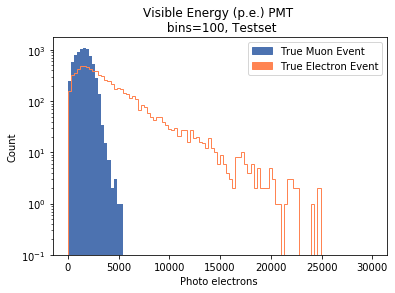

In [78]:
#### PMT Photoelectorns 
plt.hist(ViEnMuon[:,0],range=(0,30000), bins=100,histtype='stepfilled',log=True,color=colorSR)
plt.hist(ViEnEl[:,0], bins=100 ,range=(0,30000), histtype='step',log=True,color=colorMR)
plt.title("Visible Energy (p.e.) PMT \n bins=100, Testset")
plt.xlabel("Photo electrons ")
plt.ylabel("Count")
plt.grid(False)

red_patch = mpatches.Patch(color=colorSR, label='True Muon Event')
blue_patch = mpatches.Patch(color=colorMR, label='True Electron Event')


plt.legend(handles=[red_patch, blue_patch],loc='upper right')


plt.show()

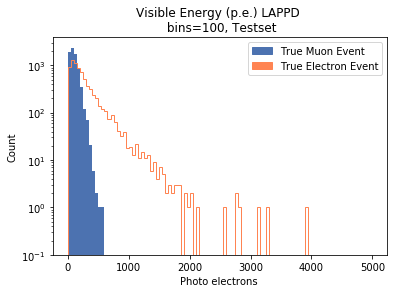

In [80]:
### LAPPD

plt.hist(ViEnMuon[:,1],range=(0,5000), bins=100,histtype='stepfilled',log=True,color=colorSR)
plt.hist(ViEnEl[:,1], bins=100 ,range=(0,5000), histtype='step',log=True,color=colorMR)
plt.title("Visible Energy (p.e.) LAPPD \n bins=100, Testset")
plt.xlabel("Photo electrons ")
plt.ylabel("Count")
plt.grid(False)

red_patch = mpatches.Patch(color=colorSR, label='True Muon Event')
blue_patch = mpatches.Patch(color=colorMR, label='True Electron Event')


plt.legend(handles=[red_patch, blue_patch],loc='upper right')


plt.show()

## Nun mit Acc

In [82]:
VisiblePMTEnergy=[]

dummyindex2=[]
Multiring_Counter2 =0
Pion_Counter2 =0

for event in range(len(feature_maps)):
    if YTest[event,1] > 0.5:
        Multiring_Counter2 = Multiring_Counter2+1
        VisiblePMTEnergy.append((float(VisibleETest[event,0]),feature_maps[event,1]))
        dummyindex2.append(0)
        
    else:
        dummyindex2.append(1)

VisiblePMTEnergy=np.array(VisiblePMTEnergy)

In [85]:
###### SingleRinge
pi1= pi2= pi3= pi4= pi5= pi6= pi7= pi8= pi9= pi10= pi11= pi12= pi13= pi14= pi15 = 0
Bin100 = Bin200 =Bin300 =Bin400 =Bin500 =Bin600 =Bin700 =Bin800 =Bin900 =Bin1000=Bin1500=Bin2000=Bin3000=Bin4000=Bin8000=0

#Range PionEn
for event in range(len(VisiblePMTEnergy)):

    if VisiblePMTEnergy[event,0]<=100 and VisiblePMTEnergy[event,1]>0.5:
        Bin100 = Bin100+1
    if VisiblePMTEnergy[event,0]<=100:
         pi1=pi1+1
        
    if 100<=VisiblePMTEnergy[event,0]<=200 and VisiblePMTEnergy[event,1]>0.5:
         Bin200 = Bin200+1
    if 100<=VisiblePMTEnergy[event,0]<=200:
         pi2=pi2+1
        
    if 200<=VisiblePMTEnergy[event,0]<=300 and VisiblePMTEnergy[event,1]>0.5:
        Bin300 = Bin300+1
    if 200<=VisiblePMTEnergy[event,0]<=300:
        pi3=pi3+1
  
    if 300<=VisiblePMTEnergy[event,0]<=400 and VisiblePMTEnergy[event,1]>0.5:
        Bin400 = Bin400+1
    if 300<=VisiblePMTEnergy[event,0]<=400:
        pi4=pi4+1
        
    if 400<=VisiblePMTEnergy[event,0]<=800 and VisiblePMTEnergy[event,1]>0.5:
        Bin500 = Bin500+1
    if 400<=VisiblePMTEnergy[event,0]<=800:
        pi5=pi5+1
        
    if 800<=VisiblePMTEnergy[event,0]<=1200 and VisiblePMTEnergy[event,1]>0.5:
        Bin600 = Bin600+1
    if 800<=VisiblePMTEnergy[event,0]<=1200:
        pi6=pi6+1
        
    if 1200<=VisiblePMTEnergy[event,0]<=1800 and VisiblePMTEnergy[event,1]>0.5:
        Bin700 = Bin700+1
    if 1200<=VisiblePMTEnergy[event,0]<=1800:
        pi7=pi7+1
        
    if 1800<=VisiblePMTEnergy[event,0]<=2500 and VisiblePMTEnergy[event,1]>0.5:
        Bin800 = Bin800+1
    if 1800<=VisiblePMTEnergy[event,0]<=2500:
        pi8=pi8+1
        
    if 2500<=VisiblePMTEnergy[event,0]<=5000 and VisiblePMTEnergy[event,1]>0.5:
        Bin900 = Bin900+1
    if 2500<=VisiblePMTEnergy[event,0]<=5000:
        pi9=pi9+1
        
    if 5000<=VisiblePMTEnergy[event,0]<=10000 and VisiblePMTEnergy[event,1]>0.5:
        Bin1000 = Bin1000+1
    if 5000<=VisiblePMTEnergy[event,0]<=10000:
        pi10=pi10+1
        
    if 10000<=VisiblePMTEnergy[event,0]<=15000 and VisiblePMTEnergy[event,1]>0.5:
        Bin1500 = Bin1500+1
    if 10000<=VisiblePMTEnergy[event,0]<=15000:
        pi11=pi11+1

    if 15000<=VisiblePMTEnergy[event,0]<=20000 and VisiblePMTEnergy[event,1]>0.5:
        Bin2000 = Bin2000+1
    if 15000<=VisiblePMTEnergy[event,0]<=20000:
        pi12=pi12+1
        
    if 20000<=VisiblePMTEnergy[event,0]<=80000 and VisiblePMTEnergy[event,1]>0.5:
        Bin3000 = Bin3000+1
    if 20000<=VisiblePMTEnergy[event,0]<=80000:
        pi13=pi13+1
        
#     if 3000<=VisiblePMTEnergy[event,0]<=4000 and VisiblePMTEnergy[event,1]>0.5:
#         Bin4000 = Bin4000+1
#     if 3000<=VisiblePMTEnergy[event,0]<=4000:
#         pi14=pi14+1
        
#     if 4000<=VisiblePMTEnergy[event,0]<=8000 and VisiblePMTEnergy[event,1]>0.5:
#         Bin8000 = Bin8000+1
#     if 4000<=VisiblePMTEnergy[event,0]<=8000:
#         pi15=pi15+1

    
print(pi1, pi2, pi3, pi4, pi5, pi6, pi7, pi8, pi9, pi10, pi11, pi12, pi13, pi14, pi15) 

VisiblePMTEnergy_AccMR=[Bin100/pi1,Bin200/pi2,Bin300/pi3,Bin400/pi4,Bin500/pi5,Bin600/pi6,Bin700/pi7,Bin800/pi8,Bin900/pi9,Bin1000/pi10]
VisiblePMTEnergy_AccMRError=(1/sqrt(pi1),1/sqrt(pi2),1/sqrt(pi3),1/sqrt(pi4),1/sqrt(pi5),1/sqrt(pi6),1/sqrt(pi7),1/sqrt(pi8),1/sqrt(pi9),1/sqrt(pi10))

errorVisiblePMTEnergyMR=[]
for i in range(10):
    errorVisiblePMTEnergyMR.append(VisiblePMTEnergy_AccMRError[i]* VisiblePMTEnergy_AccMR[i])

     

48 90 113 173 936 1205 2151 2023 792 1 0 0 0 0 0


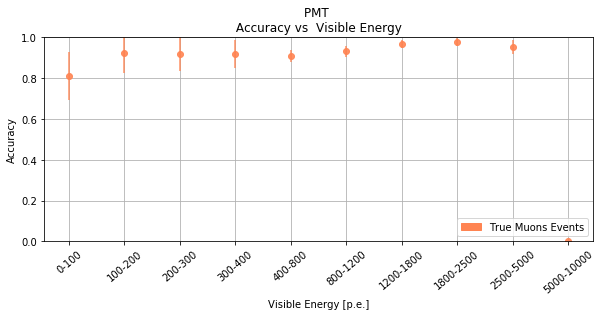

In [88]:
# plotting the points 
plt.rcParams['figure.figsize'] = [17/2, 9/2]
fig, axs = plt.subplots()
axs.grid()
x=range(0,10)

axs=plt.errorbar(x, VisiblePMTEnergy_AccMR[:11],errorVisiblePMTEnergyMR[:11],c=(1, 0.5176470588235295, 0.3215686274509804), fmt='o',alpha=0.9) 
plt.ylim(0, 1)
#red_patch = mpatches.Patch(color='red', label=' Single Rings')


blue_patch = mpatches.Patch(color=(1, 0.5176470588235295, 0.3215686274509804), label='True Muons Events')
plt.legend(handles=[blue_patch],loc='lower right')

#plt.legend()
# naming the x axis 
plt.xlabel('Visible Energy [p.e.]')



labels=("0-100","100-200","200-300","300-400","400-800","800-1200","1200-1800","1800-2500","2500-5000","5000-10000","10000-15000")
          # Get locations and labels
plt.xticks(np.arange(len(VisiblePMTEnergy_AccMR)), labels, rotation='40')

# naming the y axis 
plt.ylabel('Accuracy') 
  
# giving a title to my graph 
plt.title('PMT \n Accuracy vs  Visible Energy ') 
  
# function to show the plot 
plt.tight_layout()
plt.show() 

In [90]:
VisibleLAPPDEnergy=[]

dummyindex2=[]
Multiring_Counter2 =0
Pion_Counter2 =0
for event in range(len(feature_maps)):
    if YTest[event,1] > 0.5:
        Multiring_Counter2 = Multiring_Counter2+1
        VisibleLAPPDEnergy.append((float(VisibleETest[event,1]),feature_maps[event,1]))
        dummyindex2.append(0)
        
    else:
        dummyindex2.append(1)

VisibleLAPPDEnergy=np.array(VisibleLAPPDEnergy)

In [92]:
###### SingleRinge
pi1= pi2= pi3= pi4= pi5= pi6= pi7= pi8= pi9= pi10= pi11= pi12= pi13= pi14= pi15 = 0
Bin100 = Bin200 =Bin300 =Bin400 =Bin500 =Bin600 =Bin700 =Bin800 =Bin900 =Bin1000=Bin1500=Bin2000=Bin3000=Bin4000=Bin8000=0

#Range PionEn
for event in range(len(VisibleLAPPDEnergy)):

    if VisibleLAPPDEnergy[event,0]<=100 and VisibleLAPPDEnergy[event,1]>0.5:
        Bin100 = Bin100+1
    if VisibleLAPPDEnergy[event,0]<=100:
         pi1=pi1+1
        
    if 100<=VisibleLAPPDEnergy[event,0]<=200 and VisibleLAPPDEnergy[event,1]>0.5:
         Bin200 = Bin200+1
    if 100<=VisibleLAPPDEnergy[event,0]<=200:
         pi2=pi2+1
        
    if 200<=VisibleLAPPDEnergy[event,0]<=300 and VisibleLAPPDEnergy[event,1]>0.5:
        Bin300 = Bin300+1
    if 200<=VisibleLAPPDEnergy[event,0]<=300:
        pi3=pi3+1
  
    if 300<=VisibleLAPPDEnergy[event,0]<=400 and VisibleLAPPDEnergy[event,1]>0.5:
        Bin400 = Bin400+1
    if 300<=VisibleLAPPDEnergy[event,0]<=400:
        pi4=pi4+1
        
    if 400<=VisibleLAPPDEnergy[event,0]<=800 and VisibleLAPPDEnergy[event,1]>0.5:
        Bin500 = Bin500+1
    if 400<=VisibleLAPPDEnergy[event,0]<=800:
        pi5=pi5+1
        
    if 800<=VisibleLAPPDEnergy[event,0]<=1200 and VisibleLAPPDEnergy[event,1]>0.5:
        Bin600 = Bin600+1
    if 800<=VisibleLAPPDEnergy[event,0]<=1200:
        pi6=pi6+1
        
    if 1200<=VisibleLAPPDEnergy[event,0]<=1800 and VisibleLAPPDEnergy[event,1]>0.5:
        Bin700 = Bin700+1
    if 1200<=VisibleLAPPDEnergy[event,0]<=1800:
        pi7=pi7+1
        
    if 1800<=VisibleLAPPDEnergy[event,0]<=2500 and VisibleLAPPDEnergy[event,1]>0.5:
        Bin800 = Bin800+1
    if 1800<=VisibleLAPPDEnergy[event,0]<=2500:
        pi8=pi8+1
        
    if 2500<=VisibleLAPPDEnergy[event,0]<=5000 and VisibleLAPPDEnergy[event,1]>0.5:
        Bin900 = Bin900+1
    if 2500<=VisibleLAPPDEnergy[event,0]<=5000:
        pi9=pi9+1
        
    if 5000<=VisibleLAPPDEnergy[event,0]<=10000 and VisibleLAPPDEnergy[event,1]>0.5:
        Bin1000 = Bin1000+1
    if 5000<=VisibleLAPPDEnergy[event,0]<=10000:
        pi10=pi10+1
        
    if 10000<=VisibleLAPPDEnergy[event,0]<=15000 and VisibleLAPPDEnergy[event,1]>0.5:
        Bin1500 = Bin1500+1
    if 10000<=VisibleLAPPDEnergy[event,0]<=15000:
        pi11=pi11+1

    if 15000<=VisibleLAPPDEnergy[event,0]<=20000 and VisibleLAPPDEnergy[event,1]>0.5:
        Bin2000 = Bin2000+1
    if 15000<=VisibleLAPPDEnergy[event,0]<=20000:
        pi12=pi12+1
        
    if 20000<=VisibleLAPPDEnergy[event,0]<=80000 and VisibleLAPPDEnergy[event,1]>0.5:
        Bin3000 = Bin3000+1
    if 20000<=VisibleLAPPDEnergy[event,0]<=80000:
        pi13=pi13+1
        
#     if 3000<=VisibleLAPPDEnergy[event,0]<=4000 and VisibleLAPPDEnergy[event,1]>0.5:
#         Bin4000 = Bin4000+1
#     if 3000<=VisibleLAPPDEnergy[event,0]<=4000:
#         pi14=pi14+1
        
#     if 4000<=VisibleLAPPDEnergy[event,0]<=8000 and VisibleLAPPDEnergy[event,1]>0.5:
#         Bin8000 = Bin8000+1
#     if 4000<=VisibleLAPPDEnergy[event,0]<=8000:
#         pi15=pi15+1

    
print(pi1, pi2, pi3, pi4, pi5, pi6, pi7, pi8, pi9, pi10, pi11, pi12, pi13, pi14, pi15) 

VisibleLAPPDEnergy_AccMR=[Bin100/pi1,Bin200/pi2,Bin300/pi3,Bin400/pi4,Bin500/pi5,]
VisibleLAPPDEnergy_AccMRError=(1/sqrt(pi1),1/sqrt(pi2),1/sqrt(pi3),1/sqrt(pi4),1/sqrt(pi5))

errorVisibleLAPPDEnergyMR=[]
for i in range(5):
    errorVisibleLAPPDEnergyMR.append(VisibleLAPPDEnergy_AccMRError[i]* VisibleLAPPDEnergy_AccMR[i])

     

4339 2670 478 91 10 0 0 0 0 0 0 0 0 0 0


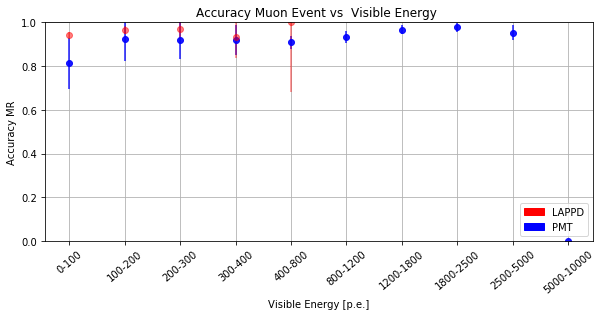

In [94]:
# plotting the points 
plt.rcParams['figure.figsize'] = [17/2, 9/2]
fig, axs = plt.subplots()
axs.grid()
x=range(0,10)
x1=range(0,5)
axs=plt.errorbar(x, VisiblePMTEnergy_AccMR[:11],errorVisiblePMTEnergyMR[:11],c='blue', fmt='o',alpha=0.9) #(1, 0.5176470588235295, 0.3215686274509804)
axs=plt.errorbar(x1, VisibleLAPPDEnergy_AccMR[:6],errorVisibleLAPPDEnergyMR[:6],c='red', fmt='o',alpha=0.5) 
plt.ylim(0, 1)
#red_patch = mpatches.Patch(color='red', label=' Single Rings')


blue_patch = mpatches.Patch(color='blue', label='PMT ')
red_patch = mpatches.Patch(color='red', label='LAPPD')
plt.legend(handles=[red_patch,blue_patch],loc='lower right')

#plt.legend()
# naming the x axis 
plt.xlabel('Visible Energy [p.e.]')



labels=("0-100","100-200","200-300","300-400","400-800","800-1200","1200-1800","1800-2500","2500-5000","5000-10000","10000-15000")
          # Get locations and labels
plt.xticks(np.arange(len(VisiblePMTEnergy_AccMR)), labels, rotation='40')
plt.tick_params(axis='both',length=4)
# naming the y axis 
plt.ylabel('Accuracy MR') 
  
# giving a title to my graph 
plt.title('Accuracy Muon Event vs  Visible Energy ') 
  
# function to show the plot 
plt.tight_layout()
plt.show() 

# Electrons

In [95]:
VisiblePMTEnergySR=[]

dummyindex2=[]
Multiring_Counter2 =0
Pion_Counter2 =0
for event in range(len(feature_maps)):
    if YTest[event,0] > 0.5:
        Multiring_Counter2 = Multiring_Counter2+1
        VisiblePMTEnergySR.append((float(VisibleETest[event,0]),feature_maps[event,0]))
        dummyindex2.append(0)
        
    else:
        dummyindex2.append(1)

VisiblePMTEnergySR=np.array(VisiblePMTEnergySR)

In [102]:
###### SingleRinge
pi1= pi2= pi3= pi4= pi5= pi6= pi7= pi8= pi9= pi10= pi11= pi12= pi13= pi14= pi15 = 0
Bin100 = Bin200 =Bin300 =Bin400 =Bin500 =Bin600 =Bin700 =Bin800 =Bin900 =Bin1000=Bin1500=Bin2000=Bin3000=Bin4000=Bin8000=0

#Range PionEn
for event in range(len(VisiblePMTEnergySR)):

    if VisiblePMTEnergySR[event,0]<=100 and VisiblePMTEnergySR[event,1]>0.5:
        Bin100 = Bin100+1
    if VisiblePMTEnergySR[event,0]<=100:
         pi1=pi1+1
        
    if 100<=VisiblePMTEnergySR[event,0]<=200 and VisiblePMTEnergySR[event,1]>0.5:
         Bin200 = Bin200+1
    if 100<=VisiblePMTEnergySR[event,0]<=200:
         pi2=pi2+1
        
    if 200<=VisiblePMTEnergySR[event,0]<=300 and VisiblePMTEnergySR[event,1]>0.5:
        Bin300 = Bin300+1
    if 200<=VisiblePMTEnergySR[event,0]<=300:
        pi3=pi3+1
  
    if 300<=VisiblePMTEnergySR[event,0]<=400 and VisiblePMTEnergySR[event,1]>0.5:
        Bin400 = Bin400+1
    if 300<=VisiblePMTEnergySR[event,0]<=400:
        pi4=pi4+1
        
    if 400<=VisiblePMTEnergySR[event,0]<=800 and VisiblePMTEnergySR[event,1]>0.5:
        Bin500 = Bin500+1
    if 400<=VisiblePMTEnergySR[event,0]<=800:
        pi5=pi5+1
        
    if 800<=VisiblePMTEnergySR[event,0]<=1200 and VisiblePMTEnergySR[event,1]>0.5:
        Bin600 = Bin600+1
    if 800<=VisiblePMTEnergySR[event,0]<=1200:
        pi6=pi6+1
        
    if 1200<=VisiblePMTEnergySR[event,0]<=1800 and VisiblePMTEnergySR[event,1]>0.5:
        Bin700 = Bin700+1
    if 1200<=VisiblePMTEnergySR[event,0]<=1800:
        pi7=pi7+1
        
    if 1800<=VisiblePMTEnergySR[event,0]<=2500 and VisiblePMTEnergySR[event,1]>0.5:
        Bin800 = Bin800+1
    if 1800<=VisiblePMTEnergySR[event,0]<=2500:
        pi8=pi8+1
        
    if 2500<=VisiblePMTEnergySR[event,0]<=5000 and VisiblePMTEnergySR[event,1]>0.5:
        Bin900 = Bin900+1
    if 2500<=VisiblePMTEnergySR[event,0]<=5000:
        pi9=pi9+1
        
    if 5000<=VisiblePMTEnergySR[event,0]<=10000 and VisiblePMTEnergySR[event,1]>0.5:
        Bin1000 = Bin1000+1
    if 5000<=VisiblePMTEnergySR[event,0]<=10000:
        pi10=pi10+1
        
    if 10000<=VisiblePMTEnergySR[event,0]<=15000 and VisiblePMTEnergySR[event,1]>0.5:
        Bin1500 = Bin1500+1
    if 10000<=VisiblePMTEnergySR[event,0]<=15000:
        pi11=pi11+1

    if 15000<=VisiblePMTEnergySR[event,0]<=20000 and VisiblePMTEnergySR[event,1]>0.5:
        Bin2000 = Bin2000+1
    if 15000<=VisiblePMTEnergySR[event,0]<=20000:
        pi12=pi12+1
        
    if 20000<=VisiblePMTEnergySR[event,0]<=80000 and VisiblePMTEnergySR[event,1]>0.5:
        Bin3000 = Bin3000+1
    if 20000<=VisiblePMTEnergySR[event,0]<=80000:
        pi13=pi13+1
        
#     if 3000<=VisiblePMTEnergySR[event,0]<=4000 and VisiblePMTEnergySR[event,1]>0.5:
#         Bin4000 = Bin4000+1
#     if 3000<=VisiblePMTEnergySR[event,0]<=4000:
#         pi14=pi14+1
        
#     if 4000<=VisiblePMTEnergySR[event,0]<=8000 and VisiblePMTEnergySR[event,1]>0.5:
#         Bin8000 = Bin8000+1
#     if 4000<=VisiblePMTEnergySR[event,0]<=8000:
#         pi15=pi15+1

    
print(pi1, pi2, pi3, pi4, pi5, pi6, pi7, pi8, pi9, pi10, pi11, pi12, pi13, pi14, pi15) 

VisiblePMTEnergySR_Acc=[Bin100/pi1,Bin200/pi2,Bin300/pi3,Bin400/pi4,Bin500/pi5,Bin600/pi6,Bin700/pi7,Bin800/pi8,Bin900/pi9,Bin1000/pi10,Bin1500/pi11,Bin2000/pi12,Bin3000/pi13]
VisiblePMTEnergySR_AccError=(1/sqrt(pi1),1/sqrt(pi2),1/sqrt(pi3),1/sqrt(pi4),1/sqrt(pi5),1/sqrt(pi6),1/sqrt(pi7),1/sqrt(pi8),1/sqrt(pi9),1/sqrt(pi10),1/sqrt(pi11),1/sqrt(pi12),1/sqrt(pi13))

errorVisiblePMTEnergySR=[]
for i in range(13):
    errorVisiblePMTEnergySR.append(VisiblePMTEnergySR_AccError[i]* VisiblePMTEnergySR_Acc[i])

     

28 56 72 97 456 577 986 1016 2330 1421 332 81 22 0 0


In [107]:
len(x),len(VisiblePMTEnergySR_Acc),len(errorVisiblePMTEnergySR)

(13, 13, 13)

10 13


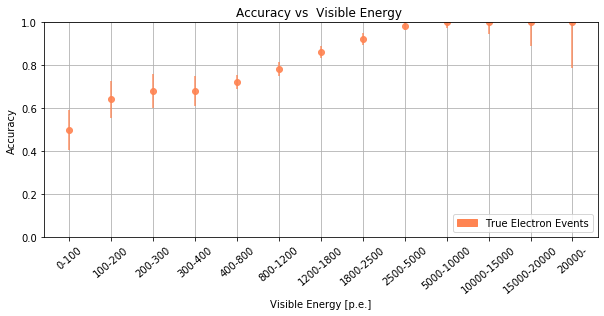

In [115]:
# plotting the points 
plt.rcParams['figure.figsize'] = [17/2, 9/2]
fig, axs = plt.subplots()
axs.grid()
x=range(0,13)

axs=plt.errorbar(x, VisiblePMTEnergySR_Acc,errorVisiblePMTEnergySR,c=(1, 0.5176470588235295, 0.3215686274509804), fmt='o',alpha=0.9) 
plt.ylim(0, 1)
#red_patch = mpatches.Patch(color='red', label=' Single Rings')


blue_patch = mpatches.Patch(color=(1, 0.5176470588235295, 0.3215686274509804), label='True Electron Events')
plt.legend(handles=[blue_patch],loc='lower right')

#plt.legend()
# naming the x axis 
plt.xlabel('Visible Energy [p.e.]')



labels=("0-100","100-200","200-300","300-400","400-800","800-1200","1200-1800","1800-2500","2500-5000","5000-10000","10000-15000","15000-20000","20000-")
          # Get locations and labels
print(len(VisiblePMTEnergy_AccMR),len(labels))
plt.xticks(np.arange(len(VisiblePMTEnergySR_Acc)), labels, rotation='40')

# naming the y axis 
plt.ylabel('Accuracy') 
  
# giving a title to my graph 
plt.title('Accuracy vs  Visible Energy ') 
  
# function to show the plot 
plt.tight_layout()
plt.show() 

In [116]:
VisibleLAPPDEnergySR=[]

dummyindex2=[]
Multiring_Counter2 =0
Pion_Counter2 =0
for event in range(len(feature_maps)):
    if YTest[event,0] > 0.5:
        Multiring_Counter2 = Multiring_Counter2+1
        VisibleLAPPDEnergySR.append((float(VisibleETest[event,1]),feature_maps[event,0]))
        dummyindex2.append(0)
        
    else:
        dummyindex2.append(1)

VisibleLAPPDEnergySR=np.array(VisibleLAPPDEnergySR)

In [123]:
###### SingleRinge
pi1= pi2= pi3= pi4= pi5= pi6= pi7= pi8= pi9= pi10= pi11= pi12= pi13= pi14= pi15 = 0
Bin100 = 0
Bin200 =0
Bin300 =0
Bin400 =0
Bin500 =0
Bin600 =0
Bin700 =0
Bin800 =0
Bin900 =0
Bin1000=0
Bin1500=0
Bin2000=0
Bin3000=0
Bin4000=0
Bin8000=0

#Range PionEn
for event in range(len(VisibleLAPPDEnergySR)):

    if VisibleLAPPDEnergySR[event,0]<=100 and VisibleLAPPDEnergySR[event,1]>0.5:
        Bin100 = Bin100+1
    if VisibleLAPPDEnergySR[event,0]<=100:
         pi1=pi1+1
        
    if 100<=VisibleLAPPDEnergySR[event,0]<=200 and VisibleLAPPDEnergySR[event,1]>0.5:
         Bin200 = Bin200+1
    if 100<=VisibleLAPPDEnergySR[event,0]<=200:
         pi2=pi2+1
        
    if 200<=VisibleLAPPDEnergySR[event,0]<=300 and VisibleLAPPDEnergySR[event,1]>0.5:
        Bin300 = Bin300+1
    if 200<=VisibleLAPPDEnergySR[event,0]<=300:
        pi3=pi3+1
  
    if 300<=VisibleLAPPDEnergySR[event,0]<=400 and VisibleLAPPDEnergySR[event,1]>0.5:
        Bin400 = Bin400+1
    if 300<=VisibleLAPPDEnergySR[event,0]<=400:
        pi4=pi4+1
        
    if 400<=VisibleLAPPDEnergySR[event,0]<=800 and VisibleLAPPDEnergySR[event,1]>0.5:
        Bin500 = Bin500+1
    if 400<=VisibleLAPPDEnergySR[event,0]<=800:
        pi5=pi5+1
        
    if 800<=VisibleLAPPDEnergySR[event,0]<=1200 and VisibleLAPPDEnergySR[event,1]>0.5:
        Bin600 = Bin600+1
    if 800<=VisibleLAPPDEnergySR[event,0]<=1200:
        pi6=pi6+1
        
    if 1200<=VisibleLAPPDEnergySR[event,0]<=1800 and VisibleLAPPDEnergySR[event,1]>0.5:
        Bin700 = Bin700+1
    if 1200<=VisibleLAPPDEnergySR[event,0]<=1800:
        pi7=pi7+1
        
    if 1800<=VisibleLAPPDEnergySR[event,0]<=2500 and VisibleLAPPDEnergySR[event,1]>0.5:
        Bin800 = Bin800+1
    if 1800<=VisibleLAPPDEnergySR[event,0]<=2500:
        pi8=pi8+1
        
    if 2500<=VisibleLAPPDEnergySR[event,0]<=5000 and VisibleLAPPDEnergySR[event,1]>0.5:
        Bin900 = Bin900+1
    if 2500<=VisibleLAPPDEnergySR[event,0]<=5000:
        pi9=pi9+1
        
    if 5000<=VisibleLAPPDEnergySR[event,0]<=10000 and VisibleLAPPDEnergySR[event,1]>0.5:
        Bin1000 = Bin1000+1
    if 5000<=VisibleLAPPDEnergySR[event,0]<=10000:
        pi10=pi10+1
        
    if 10000<=VisibleLAPPDEnergySR[event,0]<=15000 and VisibleLAPPDEnergySR[event,1]>0.5:
        Bin1500 = Bin1500+1
    if 10000<=VisibleLAPPDEnergySR[event,0]<=15000:
        pi11=pi11+1

    if 15000<=VisibleLAPPDEnergySR[event,0]<=20000 and VisibleLAPPDEnergySR[event,1]>0.5:
        Bin2000 = Bin2000+1
    if 15000<=VisibleLAPPDEnergySR[event,0]<=20000:
        pi12=pi12+1
        
    if 20000<=VisibleLAPPDEnergySR[event,0]<=80000 and VisibleLAPPDEnergySR[event,1]>0.5:
        Bin3000 = Bin3000+1
    if 20000<=VisibleLAPPDEnergySR[event,0]<=80000:
        pi13=pi13+1
        
#     if 3000<=VisibleLAPPDEnergySR[event,0]<=4000 and VisibleLAPPDEnergySR[event,1]>0.5:
#         Bin4000 = Bin4000+1
#     if 3000<=VisibleLAPPDEnergySR[event,0]<=4000:
#         pi14=pi14+1
        
#     if 4000<=VisibleLAPPDEnergySR[event,0]<=8000 and VisibleLAPPDEnergySR[event,1]>0.5:
#         Bin8000 = Bin8000+1
#     if 4000<=VisibleLAPPDEnergySR[event,0]<=8000:
#         pi15=pi15+1

    
print(pi1, pi2, pi3, pi4, pi5,) 

VisibleLAPPDEnergySR_Acc=[Bin100/pi1,Bin200/pi2,Bin300/pi3,Bin400/pi4,Bin500/pi5,Bin600/pi6,Bin700/pi7,Bin800/pi8,Bin900/pi9]
VisibleLAPPDEnergySR_AccError=(1/sqrt(pi1),1/sqrt(pi2),1/sqrt(pi3),1/sqrt(pi4),1/sqrt(pi5),1/sqrt(pi6),1/sqrt(pi7),1/sqrt(pi8),1/sqrt(pi9))

errorVisibleLAPPDEnergySR=[]
for i in range(9):
    errorVisibleLAPPDEnergySR.append(VisibleLAPPDEnergySR_AccError[i]* VisibleLAPPDEnergySR_Acc[i])

     

2233 2031 1232 698 1036


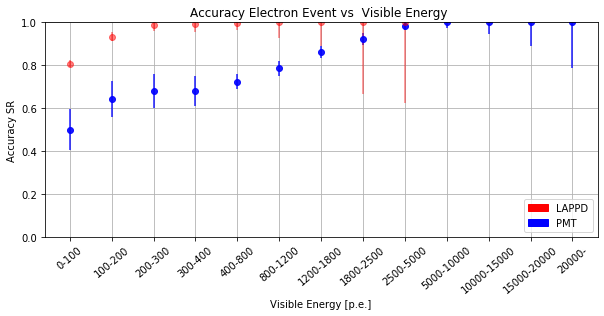

In [127]:
# plotting the points 
plt.rcParams['figure.figsize'] = [17/2, 9/2]
fig, axs = plt.subplots()
axs.grid()
x=range(0,13)
x1=range(0,9)
axs=plt.errorbar(x, VisiblePMTEnergySR_Acc,errorVisiblePMTEnergySR,c='blue', fmt='o',alpha=0.9) 
axs=plt.errorbar(x1, VisibleLAPPDEnergySR_Acc,errorVisibleLAPPDEnergySR,c='red', fmt='o',alpha=0.5) 
plt.ylim(0, 1)
#red_patch = mpatches.Patch(color='red', label=' Single Rings')


blue_patch = mpatches.Patch(color='blue', label='PMT ')
red_patch = mpatches.Patch(color='red', label='LAPPD')
plt.legend(handles=[red_patch,blue_patch],loc='lower right')

#plt.legend()
# naming the x axis 
plt.xlabel('Visible Energy [p.e.]')



labels=("0-100","100-200","200-300","300-400","400-800","800-1200","1200-1800","1800-2500","2500-5000","5000-10000","10000-15000","15000-20000","20000-")
          # Get locations and labels
plt.xticks(np.arange(len(VisiblePMTEnergySR_Acc)), labels, rotation='40')
plt.tick_params(axis='both',length=4)
# naming the y axis 
plt.ylabel('Accuracy SR') 
  
# giving a title to my graph 
plt.title('Accuracy Electron Event vs  Visible Energy ') 
  
# function to show the plot 
plt.tight_layout()
plt.show() 

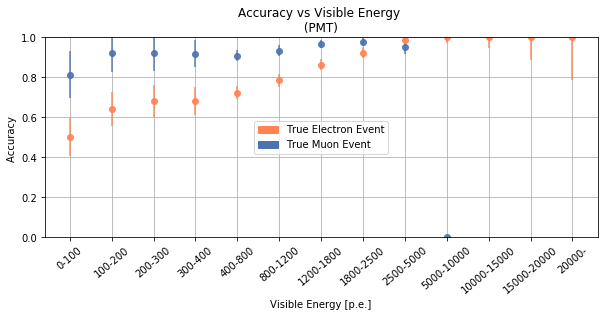

In [131]:
# plotting the points 
plt.rcParams['figure.figsize'] = [17/2, 9/2]
fig, axs = plt.subplots()
axs.grid()
x=range(0,13)
x1=range(0,10)
axs=plt.errorbar(x, VisiblePMTEnergySR_Acc,errorVisiblePMTEnergySR,c=colorMR, fmt='o',alpha=0.9) 
axs=plt.errorbar(x1, VisiblePMTEnergy_AccMR,errorVisiblePMTEnergyMR,c=colorSR, fmt='o',alpha=0.9) 
plt.ylim(0, 1)
#red_patch = mpatches.Patch(color='red', label=' Single Rings')


blue_patch = mpatches.Patch(color=colorSR, label='True Muon Event ')
red_patch = mpatches.Patch(color=colorMR, label='True Electron Event')
plt.legend(handles=[red_patch,blue_patch],loc='center')

#plt.legend()
# naming the x axis 
plt.xlabel('Visible Energy [p.e.]')



labels=("0-100","100-200","200-300","300-400","400-800","800-1200","1200-1800","1800-2500","2500-5000","5000-10000","10000-15000","15000-20000","20000-")
          # Get locations and labels
plt.xticks(np.arange(len(VisiblePMTEnergySR_Acc)), labels, rotation='40')
plt.tick_params(axis='both',length=4)
# naming the y axis 
plt.ylabel('Accuracy ') 
  
# giving a title to my graph 
plt.title('Accuracy vs Visible Energy \n (PMT) ') 
  
# function to show the plot 
plt.tight_layout()
plt.show() 

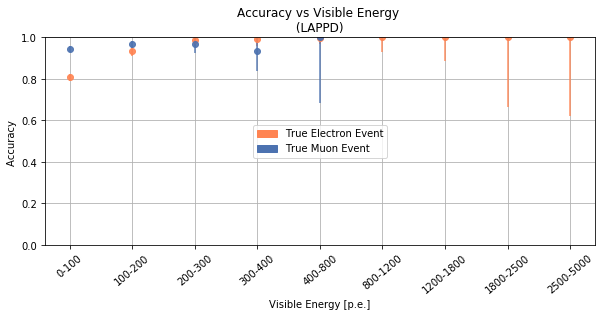

In [132]:
# plotting the points 
plt.rcParams['figure.figsize'] = [17/2, 9/2]
fig, axs = plt.subplots()
axs.grid()
x=range(0,9)
x1=range(0,5)
axs=plt.errorbar(x, VisibleLAPPDEnergySR_Acc,errorVisibleLAPPDEnergySR,c=colorMR, fmt='o',alpha=0.9) 
axs=plt.errorbar(x1, VisibleLAPPDEnergy_AccMR,errorVisibleLAPPDEnergyMR,c=colorSR, fmt='o',alpha=0.9) 
plt.ylim(0, 1)
#red_patch = mpatches.Patch(color='red', label=' Single Rings')


blue_patch = mpatches.Patch(color=colorSR, label='True Muon Event ')
red_patch = mpatches.Patch(color=colorMR, label='True Electron Event')
plt.legend(handles=[red_patch,blue_patch],loc='center')

#plt.legend()
# naming the x axis 
plt.xlabel('Visible Energy [p.e.]')



labels=("0-100","100-200","200-300","300-400","400-800","800-1200","1200-1800","1800-2500","2500-5000","5000-10000","10000-15000","15000-20000","20000-")
          # Get locations and labels
plt.xticks(np.arange(len(VisibleLAPPDEnergySR_Acc)), labels, rotation='40')
plt.tick_params(axis='both',length=4)
# naming the y axis 
plt.ylabel('Accuracy ') 
  
# giving a title to my graph 
plt.title('Accuracy vs Visible Energy \n (LAPPD) ') 
  
# function to show the plot 
plt.tight_layout()
plt.show() 

# True Parent Energy 

### Electron

In [135]:
TruePMTEnergySR=[]

dummyindex2=[]
Multiring_Counter2 =0
Pion_Counter2 =0
for event in range(len(feature_maps)):
    if YTest[event,0] > 0.5:
        Multiring_Counter2 = Multiring_Counter2+1
        TruePMTEnergySR.append((float(ParentETest[event]),feature_maps[event,0]))
        dummyindex2.append(0)
        
    else:
        dummyindex2.append(1)

TruePMTEnergySR=np.array(TruePMTEnergySR)

In [138]:
###### SingleRinge
pi1= pi2= pi3= pi4= pi5= pi6= pi7= pi8= pi9= pi10= pi11= pi12= pi13= pi14= pi15 = 0
Bin100 = Bin200 =Bin300 =Bin400 =Bin500 =Bin600 =Bin700 =Bin800 =Bin900 =Bin1000=Bin1500=Bin2000=Bin3000=Bin4000=Bin8000=0

#Range PionEn
for event in range(len(TruePMTEnergySR)):

    if TruePMTEnergySR[event,0]<=100 and TruePMTEnergySR[event,1]>0.5:
        Bin100 = Bin100+1
    if TruePMTEnergySR[event,0]<=100:
         pi1=pi1+1
        
    if 100<=TruePMTEnergySR[event,0]<=200 and TruePMTEnergySR[event,1]>0.5:
         Bin200 = Bin200+1
    if 100<=TruePMTEnergySR[event,0]<=200:
         pi2=pi2+1
        
    if 200<=TruePMTEnergySR[event,0]<=300 and TruePMTEnergySR[event,1]>0.5:
        Bin300 = Bin300+1
    if 200<=TruePMTEnergySR[event,0]<=300:
        pi3=pi3+1
  
    if 300<=TruePMTEnergySR[event,0]<=400 and TruePMTEnergySR[event,1]>0.5:
        Bin400 = Bin400+1
    if 300<=TruePMTEnergySR[event,0]<=400:
        pi4=pi4+1
        
    if 400<=TruePMTEnergySR[event,0]<=800 and TruePMTEnergySR[event,1]>0.5:
        Bin500 = Bin500+1
    if 400<=TruePMTEnergySR[event,0]<=800:
        pi5=pi5+1
        
    if 800<=TruePMTEnergySR[event,0]<=1200 and TruePMTEnergySR[event,1]>0.5:
        Bin600 = Bin600+1
    if 800<=TruePMTEnergySR[event,0]<=1200:
        pi6=pi6+1
        
    if 1200<=TruePMTEnergySR[event,0]<=1800 and TruePMTEnergySR[event,1]>0.5:
        Bin700 = Bin700+1
    if 1200<=TruePMTEnergySR[event,0]<=1800:
        pi7=pi7+1
        
    if 1800<=TruePMTEnergySR[event,0]<=2500 and TruePMTEnergySR[event,1]>0.5:
        Bin800 = Bin800+1
    if 1800<=TruePMTEnergySR[event,0]<=2500:
        pi8=pi8+1
        
    if 2500<=TruePMTEnergySR[event,0]<=5000 and TruePMTEnergySR[event,1]>0.5:
        Bin900 = Bin900+1
    if 2500<=TruePMTEnergySR[event,0]<=5000:
        pi9=pi9+1
        
    if 5000<=TruePMTEnergySR[event,0]<=10000 and TruePMTEnergySR[event,1]>0.5:
        Bin1000 = Bin1000+1
    if 5000<=TruePMTEnergySR[event,0]<=10000:
        pi10=pi10+1
        
    if 10000<=TruePMTEnergySR[event,0]<=15000 and TruePMTEnergySR[event,1]>0.5:
        Bin1500 = Bin1500+1
    if 10000<=TruePMTEnergySR[event,0]<=15000:
        pi11=pi11+1

    if 15000<=TruePMTEnergySR[event,0]<=20000 and TruePMTEnergySR[event,1]>0.5:
        Bin2000 = Bin2000+1
    if 15000<=TruePMTEnergySR[event,0]<=20000:
        pi12=pi12+1
        
    if 20000<=TruePMTEnergySR[event,0]<=80000 and TruePMTEnergySR[event,1]>0.5:
        Bin3000 = Bin3000+1
    if 20000<=TruePMTEnergySR[event,0]<=80000:
        pi13=pi13+1
        
#     if 3000<=TruePMTEnergySR[event,0]<=4000 and TruePMTEnergySR[event,1]>0.5:
#         Bin4000 = Bin4000+1
#     if 3000<=TruePMTEnergySR[event,0]<=4000:
#         pi14=pi14+1
        
#     if 4000<=TruePMTEnergySR[event,0]<=8000 and TruePMTEnergySR[event,1]>0.5:
#         Bin8000 = Bin8000+1
#     if 4000<=TruePMTEnergySR[event,0]<=8000:
#         pi15=pi15+1

    
print(pi1, pi2, pi3, pi4, pi5, pi6, pi7, pi8, pi9, pi10, pi11, pi12, pi13, pi14, pi15) 

TruePMTEnergySR_Acc=[Bin100/pi1,Bin200/pi2,Bin300/pi3,Bin400/pi4,Bin500/pi5,Bin600/pi6,Bin700/pi7,Bin800/pi8,Bin900/pi9]
TruePMTEnergySR_AccError=(1/sqrt(pi1),1/sqrt(pi2),1/sqrt(pi3),1/sqrt(pi4),1/sqrt(pi5),1/sqrt(pi6),1/sqrt(pi7),1/sqrt(pi8),1/sqrt(pi9))

errorTruePMTEnergySR=[]
for i in range(9):
    errorTruePMTEnergySR.append(TruePMTEnergySR_AccError[i]* TruePMTEnergySR_Acc[i])

     

242 461 660 680 2219 1243 896 504 569 0 0 0 0 0 0


In [107]:
len(x),len(VisiblePMTEnergySR_Acc),len(errorVisiblePMTEnergySR)

(13, 13, 13)

10 13


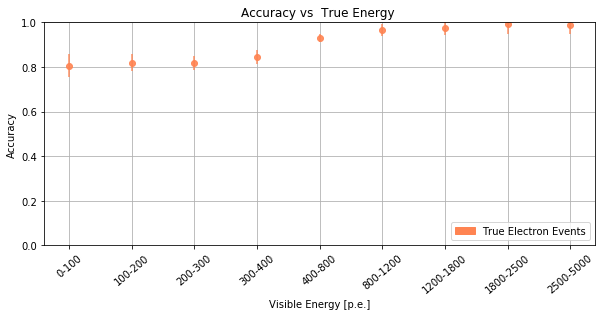

In [140]:
# plotting the points 
plt.rcParams['figure.figsize'] = [17/2, 9/2]
fig, axs = plt.subplots()
axs.grid()
x=range(0,9)

axs=plt.errorbar(x, TruePMTEnergySR_Acc,errorTruePMTEnergySR,c=(1, 0.5176470588235295, 0.3215686274509804), fmt='o',alpha=0.9) 
plt.ylim(0, 1)
#red_patch = mpatches.Patch(color='red', label=' Single Rings')


blue_patch = mpatches.Patch(color=(1, 0.5176470588235295, 0.3215686274509804), label='True Electron Events')
plt.legend(handles=[blue_patch],loc='lower right')

#plt.legend()
# naming the x axis 
plt.xlabel('Visible Energy [p.e.]')



labels=("0-100","100-200","200-300","300-400","400-800","800-1200","1200-1800","1800-2500","2500-5000","5000-10000","10000-15000","15000-20000","20000-")
          # Get locations and labels
print(len(VisiblePMTEnergy_AccMR),len(labels))
plt.xticks(np.arange(len(TruePMTEnergySR_Acc)), labels, rotation='40')

# naming the y axis 
plt.ylabel('Accuracy') 
  
# giving a title to my graph 
plt.title('Accuracy vs  True Energy ') 
  
# function to show the plot 
plt.tight_layout()
plt.show() 

In [141]:
TruePMTEnergyMR=[]

dummyindex2=[]
Multiring_Counter2 =0
Pion_Counter2 =0
for event in range(len(feature_maps)):
    if YTest[event,1] > 0.5:
        Multiring_Counter2 = Multiring_Counter2+1
        TruePMTEnergyMR.append((float(ParentETest[event]),feature_maps[event,1]))
        dummyindex2.append(0)
        
    else:
        dummyindex2.append(1)

TruePMTEnergyMR=np.array(TruePMTEnergyMR)

In [143]:
###### SingleRinge
pi1= pi2= pi3= pi4= pi5= pi6= pi7= pi8= pi9= pi10= pi11= pi12= pi13= pi14= pi15 = 0
Bin100 = Bin200 =Bin300 =Bin400 =Bin500 =Bin600 =Bin700 =Bin800 =Bin900 =Bin1000=Bin1500=Bin2000=Bin3000=Bin4000=Bin8000=0

#Range PionEn
for event in range(len(TruePMTEnergyMR)):

    if TruePMTEnergyMR[event,0]<=100 and TruePMTEnergyMR[event,1]>0.5:
        Bin100 = Bin100+1
    if TruePMTEnergyMR[event,0]<=100:
         pi1=pi1+1
        
    if 100<=TruePMTEnergyMR[event,0]<=200 and TruePMTEnergyMR[event,1]>0.5:
         Bin200 = Bin200+1
    if 100<=TruePMTEnergyMR[event,0]<=200:
         pi2=pi2+1
        
    if 200<=TruePMTEnergyMR[event,0]<=300 and TruePMTEnergyMR[event,1]>0.5:
        Bin300 = Bin300+1
    if 200<=TruePMTEnergyMR[event,0]<=300:
        pi3=pi3+1
  
    if 300<=TruePMTEnergyMR[event,0]<=400 and TruePMTEnergyMR[event,1]>0.5:
        Bin400 = Bin400+1
    if 300<=TruePMTEnergyMR[event,0]<=400:
        pi4=pi4+1
        
    if 400<=TruePMTEnergyMR[event,0]<=800 and TruePMTEnergyMR[event,1]>0.5:
        Bin500 = Bin500+1
    if 400<=TruePMTEnergyMR[event,0]<=800:
        pi5=pi5+1
        
    if 800<=TruePMTEnergyMR[event,0]<=1200 and TruePMTEnergyMR[event,1]>0.5:
        Bin600 = Bin600+1
    if 800<=TruePMTEnergyMR[event,0]<=1200:
        pi6=pi6+1
        
    if 1200<=TruePMTEnergyMR[event,0]<=1800 and TruePMTEnergyMR[event,1]>0.5:
        Bin700 = Bin700+1
    if 1200<=TruePMTEnergyMR[event,0]<=1800:
        pi7=pi7+1
        
    if 1800<=TruePMTEnergyMR[event,0]<=2500 and TruePMTEnergyMR[event,1]>0.5:
        Bin800 = Bin800+1
    if 1800<=TruePMTEnergyMR[event,0]<=2500:
        pi8=pi8+1
        
    if 2500<=TruePMTEnergyMR[event,0]<=5000 and TruePMTEnergyMR[event,1]>0.5:
        Bin900 = Bin900+1
    if 2500<=TruePMTEnergyMR[event,0]<=5000:
        pi9=pi9+1
        
    if 5000<=TruePMTEnergyMR[event,0]<=10000 and TruePMTEnergyMR[event,1]>0.5:
        Bin1000 = Bin1000+1
    if 5000<=TruePMTEnergyMR[event,0]<=10000:
        pi10=pi10+1
        
    if 10000<=TruePMTEnergyMR[event,0]<=15000 and TruePMTEnergyMR[event,1]>0.5:
        Bin1500 = Bin1500+1
    if 10000<=TruePMTEnergyMR[event,0]<=15000:
        pi11=pi11+1

    if 15000<=TruePMTEnergyMR[event,0]<=20000 and TruePMTEnergyMR[event,1]>0.5:
        Bin2000 = Bin2000+1
    if 15000<=TruePMTEnergyMR[event,0]<=20000:
        pi12=pi12+1
        
    if 20000<=TruePMTEnergyMR[event,0]<=80000 and TruePMTEnergyMR[event,1]>0.5:
        Bin3000 = Bin3000+1
    if 20000<=TruePMTEnergyMR[event,0]<=80000:
        pi13=pi13+1
        
#     if 3000<=TruePMTEnergyMR[event,0]<=4000 and TruePMTEnergyMR[event,1]>0.5:
#         Bin4000 = Bin4000+1
#     if 3000<=TruePMTEnergyMR[event,0]<=4000:
#         pi14=pi14+1
        
#     if 4000<=TruePMTEnergyMR[event,0]<=8000 and TruePMTEnergyMR[event,1]>0.5:
#         Bin8000 = Bin8000+1
#     if 4000<=TruePMTEnergyMR[event,0]<=8000:
#         pi15=pi15+1

    
print(pi1, pi2, pi3, pi4, pi5, pi6, pi7, pi8, pi9, pi10, pi11, pi12, pi13, pi14, pi15) 

TruePMTEnergyMR_Acc=[0,Bin200/pi2,Bin300/pi3,Bin400/pi4,Bin500/pi5,Bin600/pi6,Bin700/pi7,Bin800/pi8,Bin900/pi9]
TruePMTEnergyMR_AccError=(0,1/sqrt(pi2),1/sqrt(pi3),1/sqrt(pi4),1/sqrt(pi5),1/sqrt(pi6),1/sqrt(pi7),1/sqrt(pi8),1/sqrt(pi9))

errorTruePMTEnergyMR=[]
for i in range(9):
    errorTruePMTEnergyMR.append(TruePMTEnergyMR_AccError[i]* TruePMTEnergyMR_Acc[i])

     

0 20 364 1008 3677 1247 654 267 285 9 0 0 0 0 0


In [144]:
len(x),len(TruePMTEnergyMR_Acc)

(9, 9)

10 13


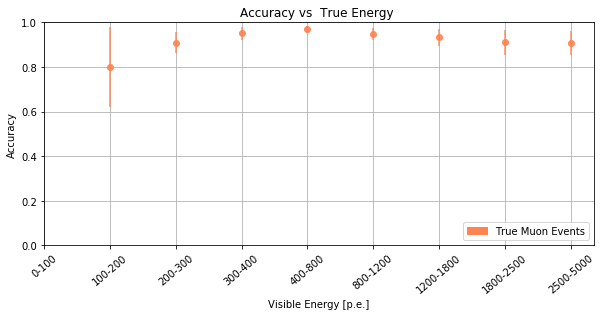

In [146]:
# plotting the points 
plt.rcParams['figure.figsize'] = [17/2, 9/2]
fig, axs = plt.subplots()
axs.grid()
x=range(1,9)

axs=plt.errorbar(x, TruePMTEnergyMR_Acc[1:],errorTruePMTEnergyMR[1:],c=(1, 0.5176470588235295, 0.3215686274509804), fmt='o',alpha=0.9) 
plt.ylim(0, 1)
#red_patch = mpatches.Patch(color='red', label=' Single Rings')


blue_patch = mpatches.Patch(color=(1, 0.5176470588235295, 0.3215686274509804), label='True Muon Events')
plt.legend(handles=[blue_patch],loc='lower right')

#plt.legend()
# naming the x axis 
plt.xlabel('Visible Energy [p.e.]')



labels=("0-100","100-200","200-300","300-400","400-800","800-1200","1200-1800","1800-2500","2500-5000","5000-10000","10000-15000","15000-20000","20000-")
          # Get locations and labels
print(len(VisiblePMTEnergy_AccMR),len(labels))
plt.xticks(np.arange(len(TruePMTEnergyMR_Acc)), labels, rotation='40')

# naming the y axis 
plt.ylabel('Accuracy') 
  
# giving a title to my graph 
plt.title('Accuracy vs  True Energy ') 
  
# function to show the plot 
plt.tight_layout()
plt.show() 

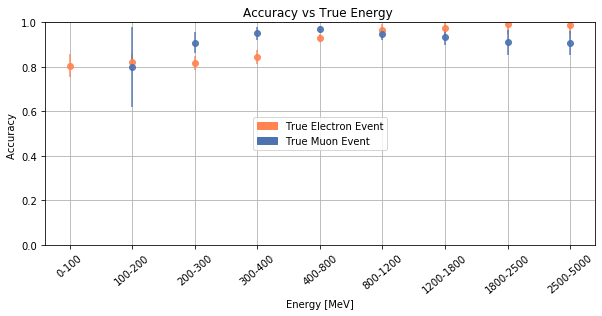

In [151]:
# plotting the points 
plt.rcParams['figure.figsize'] = [17/2, 9/2]
fig, axs = plt.subplots()
axs.grid()
x=range(0,9)
x1=range(1,9)
axs=plt.errorbar(x, TruePMTEnergySR_Acc,errorTruePMTEnergySR,c=colorMR, fmt='o',alpha=0.9) 
axs=plt.errorbar(x1,TruePMTEnergyMR_Acc[1:],errorTruePMTEnergyMR[1:],c=colorSR, fmt='o',alpha=0.9) 
plt.ylim(0, 1)
#red_patch = mpatches.Patch(color='red', label=' Single Rings')


blue_patch = mpatches.Patch(color=colorSR, label='True Muon Event ')
red_patch = mpatches.Patch(color=colorMR, label='True Electron Event')
plt.legend(handles=[red_patch,blue_patch],loc='center')

#plt.legend()
# naming the x axis 
plt.xlabel('Energy [MeV]')



labels=("0-100","100-200","200-300","300-400","400-800","800-1200","1200-1800","1800-2500","2500-5000","5000-10000","10000-15000","15000-20000","20000-")
          # Get locations and labels
plt.xticks(np.arange(len(TruePMTEnergyMR_Acc)), labels, rotation='40')
plt.tick_params(axis='both',length=4)
# naming the y axis 
plt.ylabel('Accuracy ') 
  
# giving a title to my graph 
plt.title('Accuracy vs True Energy ') 
  
# function to show the plot 
plt.tight_layout()
plt.show() 

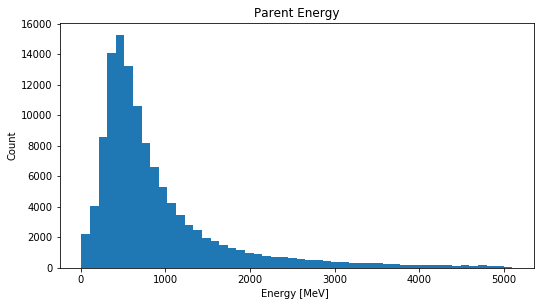

In [150]:
plt.hist(ParentE, bins=50,histtype='stepfilled')
plt.title("Parent Energy")
plt.xlabel("Energy [MeV] ")
plt.ylabel("Count")
plt.grid(False)
plt.show()

In [158]:
EnerglisteSR=[]
RightEventsSR=[]
EnerglisteMR=[]
RightEventsMR=[]
for event in range(len(feature_maps)):
    if YTest[event,0]>0.5 and feature_maps[event,0]>0.5:
        RightEventsSR.append(feature_maps[event,0])
        EnerglisteSR.append(ParentETest[event])
    if YTest[event,1]>0.5 and feature_maps[event,1]>0.5:
        RightEventsMR.append(feature_maps[event,0])
        EnerglisteMR.append(ParentETest[event])


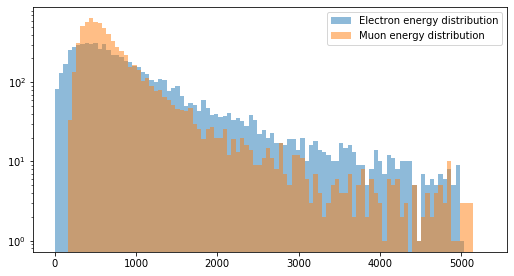

In [159]:
plt.hist(EnerglisteSR,range=(0,5300), bins=100, alpha=0.5,log=True, label='Electron energy distribution')
plt.hist(EnerglisteMR,range=(0,5300), bins=100, alpha=0.5,log=True, label='Muon energy distribution')
plt.legend(loc='upper right')
plt.show()

Histogramm Muon

In [165]:
x = feature_maps[:,1]
x1=[]
x2=[]


for value in range(len(x)):
    if YTest[value,1] > YTest[value,0]:
        x1.append(x[value])
        x2.append(1-x[value])
    
y = feature_maps[:,0]
y1=[]
y2=[]
for value in range(len(y)):
    if YTest[value,1] < YTest[value,0]:
        y1.append(y[value])
        y2.append(1-y[value])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


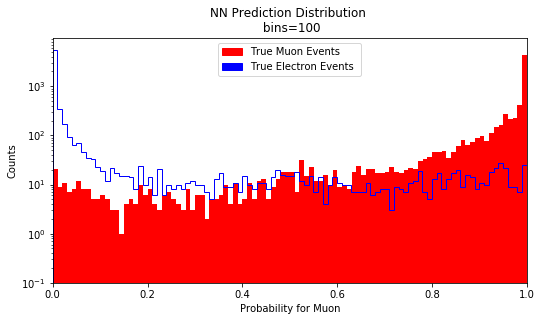

In [169]:
plt.hist(x1 ,bins=100,align='mid', color='red',histtype='stepfilled', log=True)
plt.hist(y2,bins=100,histtype='step',normed=False,color='blue',align='mid',log=True)
plt.xlim(0.0,1)

red_patch = mpatches.Patch(color='red', label='True Muon Events')


blue_patch = mpatches.Patch(color='blue', label='True Electron Events ')

plt.legend(handles=[red_patch,
                    #purple_patch,
                    blue_patch],loc='upper center')

plt.xlabel('Probability for Muon') 
# naming the y axis 
plt.ylabel('Counts') 
  
# giving a title to my graph 
plt.title('NN Prediction Distribution \n bins=100')
plt.show()

In [171]:
Y[1]

array([1, 0])

# Purity Efficiency and rel Uncertanty

In [170]:
unique, counts = np.unique(YTest, return_counts=True, axis=0)
print("How much from one kind, how much from the other: \n",counts)
print("How do they look like? \n",unique)
print("Percentage of one kind: \n", 100/(counts[0]+counts[1])*counts[1])

How much from one kind, how much from the other: 
 [7531 7474]
How do they look like? 
 [[0 1]
 [1 0]]
Percentage of one kind: 
 49.81006331222926


In [174]:
from tqdm.notebook import tqdm

Schnitt = np.arange(0,1.0, 0.001)
x = feature_maps[:,0]
x1=[]
x2=[]


for value in range(len(x)):
    if YTest[value,0] > YTest[value,1]:
        x1.append(x[value])
        x2.append(1-x[value])
    
y = feature_maps[:,1]
y1=[]
y2=[]
for value in range(len(y)):
    if YTest[value,0] < YTest[value,1]:
        y1.append(y[value])
        y2.append(1-y[value])


index=0

SR_list = []
MR_list = []

SR_PKA = []
MR_PKA = []

for cut in tqdm(Schnitt):
        
#     if cut== 0.9500000000000001:####0.127: ##0.127:        #0.9500000000000001:
#         print(counter,counter2,"TM_NM = ",TM_NM ,"TM_NS ",TM_NS ,"TS_NM =",TS_NM,"TS_NS =", TS_NS)
#         break
        
  
    
    liste_TrueSR_NNSR=[]
    liste2_TrueMR_NNMR=[]
    
    counter=counter2=counter3=TM_NM=TM_NS=TS_NM=TS_NS=0
    for event in x:
        
        if event >= cut:
            counter=counter+1
            if YTest[counter3,0] > YTest[counter3,1]:
                #Netzwerk denkt SR, ist auch TRUE SR
                TS_NS = TS_NS+1
            if YTest[counter3,0] < YTest[counter3,1]:
                #Netzwerk denkt SR, ist aber TRUE MR
                
                TM_NS = TM_NS+1
        else:
            counter2 = counter2+1
            if YTest[counter3,0] > YTest[counter3,1]:
                #Netzwerk denkt MR, ist aber TRUE SR
                TS_NM = TS_NM+1
            if YTest[counter3,0] < YTest[counter3,1]:
                TM_NM = TM_NM+1
        counter3 = counter3+1      
                
    for event in range(len(x1)):
        if x1[event] > cut:   #NN-Werte für True-SR N=6105
            liste_TrueSR_NNSR.append(event)
            #man arbeitet mit der Länge der Liste 

    for event in range(len(y1)):      
        if y1[event] > cut:   #NN-Werte für Ture-MR
            liste2_TrueMR_NNMR.append(event)
            #man arbeitet mit der Länge der Liste

    wrongliste=[]
    trueliste=[]
    
    for event in y2: #True MR, allerdings 1-Minus-prediction für Multiringe. dh. flasch klassifiziert ist über 0.5, richitg klassiziert unter 0.5
        if event > cut:
            wrongliste.append(event) #NN denkt SR, Event ist aber True MR, #unten links in der CM
        else:
            trueliste.append(event)  #NN denkt MR, Event ist      True MR  #unten rechts in der CM
    
    
    
    wrongliste2=[]
    trueliste2=[]
    
    for event in x2: #True SR, allerdings Werte der 1-Minus-prediction für SR. dh. flasch klassifiziert ist über 0.5, richitg klassiziert unter 0.5
        if event > cut:
            wrongliste2.append(event) #NN denkt MR, Event ist aber True SR, #oben rechts in der CM
        else:
            trueliste2.append(event)  #NN denkt SR, Event ist       True SR, #oben links in der CM
            

    
    AccurnecySR = 1/(len(liste_TrueSR_NNSR)+len(wrongliste2)) * len(liste_TrueSR_NNSR)
    AccurnecyMR = 1/(len(liste2_TrueMR_NNMR)+len(wrongliste)) * len(liste2_TrueMR_NNMR)
    
    PuritySR = 1/(len(liste_TrueSR_NNSR)+len(wrongliste)) * len(liste_TrueSR_NNSR)
    PurityMR = 1/(len(liste2_TrueMR_NNMR)+len(wrongliste2)) * len(liste2_TrueMR_NNMR)
    
    relPuritySR = sqrt(len(liste_TrueSR_NNSR)+len(wrongliste)) / len(liste_TrueSR_NNSR)
    relPurityMR = sqrt(len(liste2_TrueMR_NNMR)+len(wrongliste2)) / len(liste2_TrueMR_NNMR)
    
    relPuritySR2 = sqrt(TS_NS+TM_NS) /TS_NS
    relPurityMR2 = sqrt(TM_NM+TS_NM) /TM_NM
        
    relPuritySR3 = sqrt(TS_NS+TM_NS) /TS_NS
    relPurityMR3 = sqrt(TM_NM+TS_NM) /TM_NM
    
    Res_SR = len(liste_TrueSR_NNSR)/7474#  
    Res_SR_Pol = len(wrongliste)/(len(liste_TrueSR_NNSR)+len(wrongliste))
    Res_SR_Pol2 = len(wrongliste)/7531
    Res_MR = len(liste2_TrueMR_NNMR)/7531  #4336
    Res_MR_Pol = len(wrongliste2)/(len(liste2_TrueMR_NNMR)+len(wrongliste2))
    Res_MR_Pol2 = len(wrongliste2)/7474
    
    Acc_Pur_SR = AccurnecySR*PuritySR
    Acc_Pur_MR = AccurnecyMR*PurityMR
    
    
    
    SR_list.append((Acc_Pur_SR,Res_SR,AccurnecySR,PuritySR,Res_SR*PuritySR**2,relPuritySR,relPuritySR2,Res_SR_Pol,Res_SR_Pol2,len(liste_TrueSR_NNSR),len(wrongliste)))
    MR_list.append((Acc_Pur_MR,Res_MR,AccurnecyMR,PurityMR,Res_MR*PurityMR**2,relPurityMR,relPurityMR2,Res_MR_Pol,Res_MR_Pol2,len(liste2_TrueMR_NNMR),len(wrongliste2)))

#     print( "Selected Cut: ", cut)
#     print("Accurnecy SR:", AccurnecySR)
#     print("Accurnecy SR:", AccurnecyMR)
    
#     print("Purity SR: ", PuritySR)
#     print("Purity MR: ", PurityMR)   

#     print("Accurnecy SR * Purity SR",AccurnecySR*PuritySR )
#     print("Accurnecy MR * Purity MR",AccurnecyMR*PurityMR )
    
#     print("Data remaining SR: ", Res_SR*100, "%")
#     print("Data remaining MR: ",Res_MR*100 ,"%")
    
#     print("----------------------------------------","\n \n \n \n ","----------------------------------------")
    
# Purity: CM vertikal
# ACC : CM horizontal
SR_list = np.array(SR_list)
MR_list = np.array(MR_list)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in double_scalars


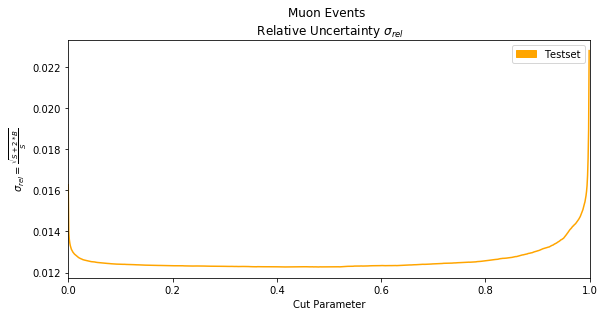

In [177]:
SR_list = np.array(SR_list)
MR_list = np.array(MR_list)

plt.plot(Schnitt, MR_list[:,5],c='orange',alpha=1)#relative uncertainty #*55

orange_patch = mpatches.Patch(color='orange', label='Testset')#Relative uncertainty

plt.xlim(0, 1)


plt.legend(handles=[

                   ],loc='best')
#plt.legend()
# naming the x axis 
plt.xlabel('Cut Parameter') 
# naming the y axis 
plt.ylabel(r'$\sigma_{rel}=\frac{\sqrt{S+2*B}}{S}$') 
  
# giving a title to my graph 
plt.title('Muon Events \n Relative Uncertainty $\sigma_{rel}$') 
  
# function to show the plot 
plt.tight_layout()
plt.show() 

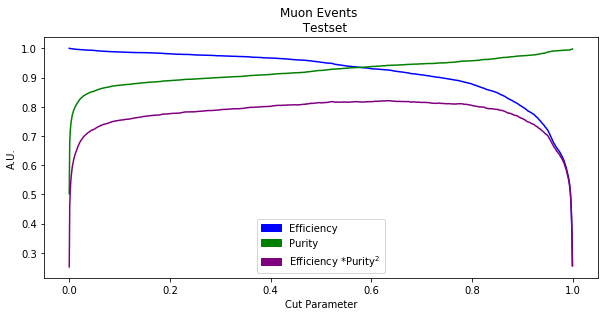

In [180]:
plt.rcParams['figure.figsize'] = [17/2, 9/2]

plt.plot(Schnitt, MR_list[:,1],c='blue',alpha=1)#Efficiency 
plt.plot(Schnitt, MR_list[:,3],c='green',alpha=1)#Purity
#plt.plot(Schnitt, SR_list[:,4],c='purple',alpha=1) #efficency*purity**2
plt.plot(Schnitt, MR_list[:,1]*MR_list[:,3]*MR_list[:,3],c='purple',alpha=1)


green_patch= mpatches.Patch(color='green', label='Purity')
blue_patch = mpatches.Patch(color='blue', label='Efficiency')
purple_patch = mpatches.Patch(color='purple', label=r'Efficiency *Purity$^2$')


plt.legend(handles=[blue_patch, green_patch,purple_patch],loc='best')
#plt.legend()
# naming the x axis 
plt.xlabel('Cut Parameter') 
# naming the y axis 
plt.ylabel('A.U.') 
  
# giving a title to my graph 
plt.title('Muon Events \n  Testset') 
  
# function to show the plot 
plt.tight_layout()
plt.show() 

# MRD Cluster vs Muon Acc.

In [197]:
feature_maps[counter,1],YTest[counter,1]==1

(0.9950021, True)

In [199]:
####### MRD Cluster Set#######

counter=0

NewYTest1=[]
FeatureMap1=[]

for x in XMRDTest:
    if x[0]==0 and YTest[counter,1]==1 and feature_maps[counter,1]>0.5:
        FeatureMap1.append(feature_maps[counter])
        NewYTest1.append(YTest[counter])

    counter=counter+1
counter=0
NewYTest2=[]
FeatureMap2=[]
for x in XMRDTest:
    if x[0]==1 and YTest[counter,1]==1 and feature_maps[counter,1]>0.5:
        FeatureMap2.append(feature_maps[counter])
        NewYTest2.append(YTest[counter])

    counter=counter+1
counter=0
NewYTest3=[]
FeatureMap3=[]

for x in XMRDTest:
    if x[0]==2 and YTest[counter,1]==1 and feature_maps[counter,1]>0.5:
        FeatureMap3.append(feature_maps[counter])
        NewYTest3.append(YTest[counter])

    counter=counter+1
counter=0
    

NewYTest1=np.array(NewYTest1)
NewYTest2=np.array(NewYTest2)
NewYTest3=np.array(NewYTest3)

FeatureMap1= np.array(FeatureMap1)
FeatureMap2= np.array(FeatureMap2)
FeatureMap3= np.array(FeatureMap3)

In [200]:
counter=0

TNewYTest1=[]
TFeatureMap1=[]

for x in XMRDTest:
    if x[0]==0 and YTest[counter,1]==1:
        TFeatureMap1.append(feature_maps[counter])
        TNewYTest1.append(YTest[counter])

    counter=counter+1
counter=0
TNewYTest2=[]
TFeatureMap2=[]
for x in XMRDTest:
    if x[0]==1 and YTest[counter,1]==1:
        TFeatureMap2.append(feature_maps[counter])
        TNewYTest2.append(YTest[counter])

    counter=counter+1
counter=0
TNewYTest3=[]
TFeatureMap3=[]

for x in XMRDTest:
    if x[0]==2 and YTest[counter,1]==1:
        TFeatureMap3.append(feature_maps[counter])
        TNewYTest3.append(YTest[counter])

    counter=counter+1
counter=0
    

TNewYTest1=np.array(TNewYTest1)
TNewYTest2=np.array(TNewYTest2)
TNewYTest3=np.array(TNewYTest3)

TFeatureMap1= np.array(TFeatureMap1)
TFeatureMap2= np.array(TFeatureMap2)
TFeatureMap3= np.array(TFeatureMap3)

In [201]:
Acc0=[len(NewYTest1)/len(TNewYTest1),len(NewYTest2)/len(TNewYTest2),len(NewYTest3)/len(TNewYTest3)]
AccError0=(1/sqrt(len(TNewYTest1)),1/sqrt(len(TNewYTest2)),1/sqrt(len(TNewYTest3)))

errorACC0=[]
for i in range(3):
    errorACC0.append(AccError0[i]* Acc0[i])


In [209]:
len(NewYTest3),len(TNewYTest3),errorACC0[2]

(2, 2, 0.7071067811865475)

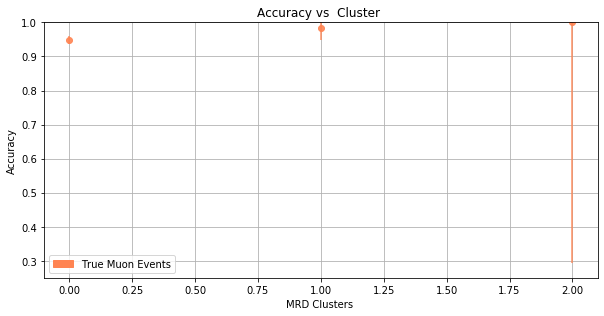

In [212]:
# plotting the points 
plt.rcParams['figure.figsize'] = [17/2, 9/2]
fig, axs = plt.subplots()
axs.grid()
x=range(0,3)

axs=plt.errorbar(x, Acc0,errorACC0,c=(1, 0.5176470588235295, 0.3215686274509804), fmt='o',alpha=0.9) 
plt.ylim(0.25, 1)
#red_patch = mpatches.Patch(color='red', label=' Single Rings')


blue_patch = mpatches.Patch(color=(1, 0.5176470588235295, 0.3215686274509804), label='True Muon Events')
plt.legend(handles=[blue_patch],loc='lower left')

#plt.legend()
# naming the x axis 
plt.xlabel('MRD Clusters ')



#labels=("0-100","100-200","200-300","300-400","400-800","800-1200","1200-1800","1800-2500","2500-5000","5000-10000","10000-15000","15000-20000","20000-")
          # Get locations and labels
#print(len(VisiblePMTEnergy_AccMR),len(labels))
#plt.xticks(np.arange(len(TruePMTEnergyMR_Acc)), labels, rotation='40')

# naming the y axis 
plt.ylabel('Accuracy') 
  
# giving a title to my graph 
plt.title('Accuracy vs  Cluster ') 
  
# function to show the plot 
plt.tight_layout()
plt.show() 

# CNN überprüung des Clusters

W0604 19:09:05.546962 22748 deprecation.py:323] From C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\Tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 10, 24, 160)       3040      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 12, 160)        0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 5, 12, 160)        640       
_________________________________________________________________
dropout_30 (Dropout)         (None, 5, 12, 160)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 5, 12, 160)        230560    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 3, 6, 160)         0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 3, 6, 160)         6

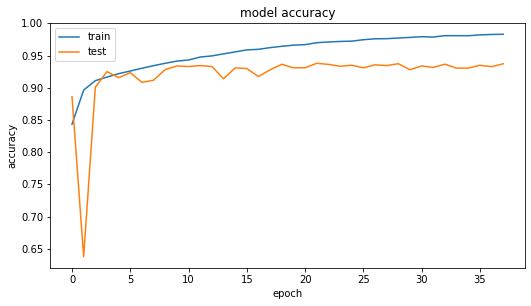

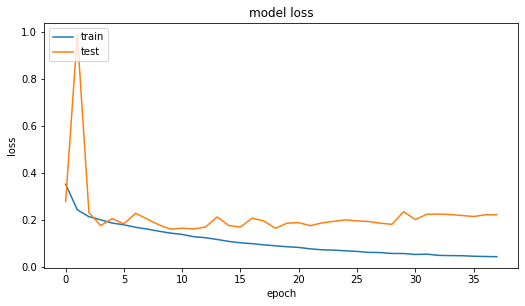

Ende des Versuchs: 


In [213]:
dense_layers = [3]
layer_sizes = [160]
conv_layers = [3]
kernal_size = [(3,3)]
for filter_size in kernal_size:
    for dense_layer in dense_layers:
        for layer_size in layer_sizes:
            for conv_layer in conv_layers:

                NAME ="PMT-MuEl-{}-filter_size-{}-conv-{}-nodes-{}-dense".format(filter_size,conv_layer, layer_size, dense_layer) #,int(time.time())
                tensorboard = TensorBoard(log_dir = 'logs\PMTplusLAPPD_CNN\{}'.format(NAME))


                model = Sequential()
                model.add(Conv2D(layer_size,filter_size,strides=1, input_shape= XTraining.shape[1:],activation="relu", padding='same'))                                               
                model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
                model.add(BatchNormalization())
                model.add(Dropout(0.2))
                for l in range(conv_layer-1):                   
                    model.add(Conv2D(layer_size,filter_size,padding='same',activation="relu"))              
                    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
                    model.add(BatchNormalization())
                    model.add(Dropout(0.2))            
                #model.add(GlobalAveragePooling2D())
                model.add(Flatten())
                for l in range(dense_layer-1):
                    model.add(Dense(512-l*20 ,activation="relu" ))
                    model.add(BatchNormalization())
                    model.add(Dropout(0.2))
                model.add(Dense(32,activation="relu"))
                model.add(BatchNormalization())
                model.add(Dropout(0.2))
                model.add(Dense(2))
                model.add(Activation('softmax'))
                #adam = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=True, epsilon = 0.001)
                model.compile(loss="binary_crossentropy",
                             optimizer="adam",
                              metrics=['accuracy']
                             )   
                filepath="CNN-Det+MRD-improvement_EnergyTester-val-acc_{val_acc:.2f}.model"  
                checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
                #monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=False)
                model.summary()
                history=model.fit(
                    
                    XTraining,YTraining,
              #validation_data=(XVal,Yval)
                 validation_data=(XVal,YVal)   
                    
              ,batch_size=100,
                shuffle=True,
                class_weight='balanced',
                callbacks=[
                            #monitor,
                            checkpoint,
                            #tensorboard 
                ],
              epochs= 38)
                print(history.history.keys())
                # summarize history for accuracy
                plt.plot(history.history['acc'])
                plt.plot(history.history['val_acc'])
                plt.title('model accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                plt.legend(['train', 'test'], loc='upper left')
                plt.show()
                # summarize history for loss
                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('model loss')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                plt.legend(['train', 'test'], loc='upper left')
                plt.show()

                print("Ende des Versuchs: ")
            

In [214]:
model = tf.keras.models.load_model("CNN-Det+MRD-improvement_EnergyTester-val-acc_0.94.model")

In [215]:
feature_maps = model.predict(XTest)

In [216]:
####### MRD Cluster Set#######

counter=0

NewYTest1=[]
FeatureMap1=[]

for x in XMRDTest:
    if x[0]==0 and YTest[counter,1]==1 and feature_maps[counter,1]>0.5:
        FeatureMap1.append(feature_maps[counter])
        NewYTest1.append(YTest[counter])

    counter=counter+1
counter=0
NewYTest2=[]
FeatureMap2=[]
for x in XMRDTest:
    if x[0]==1 and YTest[counter,1]==1 and feature_maps[counter,1]>0.5:
        FeatureMap2.append(feature_maps[counter])
        NewYTest2.append(YTest[counter])

    counter=counter+1
counter=0
NewYTest3=[]
FeatureMap3=[]

for x in XMRDTest:
    if x[0]==2 and YTest[counter,1]==1 and feature_maps[counter,1]>0.5:
        FeatureMap3.append(feature_maps[counter])
        NewYTest3.append(YTest[counter])

    counter=counter+1
counter=0
    

NewYTest1=np.array(NewYTest1)
NewYTest2=np.array(NewYTest2)
NewYTest3=np.array(NewYTest3)

FeatureMap1= np.array(FeatureMap1)
FeatureMap2= np.array(FeatureMap2)
FeatureMap3= np.array(FeatureMap3)
counter=0

TNewYTest1=[]
TFeatureMap1=[]

for x in XMRDTest:
    if x[0]==0 and YTest[counter,1]==1:
        TFeatureMap1.append(feature_maps[counter])
        TNewYTest1.append(YTest[counter])

    counter=counter+1
counter=0
TNewYTest2=[]
TFeatureMap2=[]
for x in XMRDTest:
    if x[0]==1 and YTest[counter,1]==1:
        TFeatureMap2.append(feature_maps[counter])
        TNewYTest2.append(YTest[counter])

    counter=counter+1
counter=0
TNewYTest3=[]
TFeatureMap3=[]

for x in XMRDTest:
    if x[0]==2 and YTest[counter,1]==1:
        TFeatureMap3.append(feature_maps[counter])
        TNewYTest3.append(YTest[counter])

    counter=counter+1
counter=0
    

TNewYTest1=np.array(TNewYTest1)
TNewYTest2=np.array(TNewYTest2)
TNewYTest3=np.array(TNewYTest3)

TFeatureMap1= np.array(TFeatureMap1)
TFeatureMap2= np.array(TFeatureMap2)
TFeatureMap3= np.array(TFeatureMap3)

In [217]:
AccC=[len(NewYTest1)/len(TNewYTest1),len(NewYTest2)/len(TNewYTest2),len(NewYTest3)/len(TNewYTest3)]
AccErrorC=(1/sqrt(len(TNewYTest1)),1/sqrt(len(TNewYTest2)),1/sqrt(len(TNewYTest3)))

errorACCC=[]
for i in range(3):
    errorACCC.append(AccErrorC[i]* AccC[i])


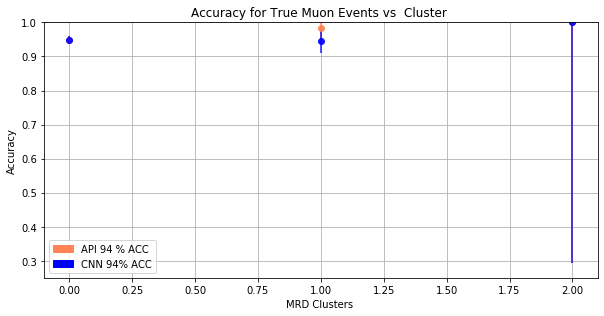

In [218]:
# plotting the points 
plt.rcParams['figure.figsize'] = [17/2, 9/2]
fig, axs = plt.subplots()
axs.grid()
x=range(0,3)

axs=plt.errorbar(x, Acc0,errorACC0,c=(1, 0.5176470588235295, 0.3215686274509804), fmt='o',alpha=0.9) 
axs=plt.errorbar(x, AccC,errorACCC,c='blue', fmt='o',alpha=0.9) 
plt.ylim(0.25, 1)
#red_patch = mpatches.Patch(color='red', label=' Single Rings')


blue_patch = mpatches.Patch(color=(1, 0.5176470588235295, 0.3215686274509804), label='API 94 % ACC')
blueish_patch = mpatches.Patch(color='blue', label='CNN 94% ACC')
plt.legend(handles=[blue_patch,blueish_patch],loc='lower left')

#plt.legend()
# naming the x axis 
plt.xlabel('MRD Clusters ')



#labels=("0-100","100-200","200-300","300-400","400-800","800-1200","1200-1800","1800-2500","2500-5000","5000-10000","10000-15000","15000-20000","20000-")
          # Get locations and labels
#print(len(VisiblePMTEnergy_AccMR),len(labels))
#plt.xticks(np.arange(len(TruePMTEnergyMR_Acc)), labels, rotation='40')

# naming the y axis 
plt.ylabel('Accuracy') 
  
# giving a title to my graph 
plt.title('Accuracy for True Muon Events vs  Cluster ') 
  
# function to show the plot 
plt.tight_layout()
plt.show() 